## 1. Introduction

This Exploratory Data Analysis (EDA) delves into historical Bitcoin data to uncover insights for developing a **dynamic Dollar Cost Averaging (DCA)** strategy. The primary **project goal** is to generalize traditional DCA by enabling dynamic daily purchase allocations. This approach aims to maximize the **Satoshis per Dollar (SPD) percentile** achieved, while still adhering to the core DCA principle of regular, systematic purchases.

The **purpose of this EDA** is twofold:
1.  To identify and evaluate potential features derived from market and on-chain data that could effectively inform such a dynamic allocation model.
2.  To explore and understand the characteristics and implications of different baseline annual allocation strategies, considering the project's specific constraints.

This analysis will particularly focus on addressing these **core questions**:
* Can more complex on-chain and market-derived features offer significantly more actionable insights for Bitcoin accumulation than a simpler Price Z-Score?
* What are the practical implications of various baseline annual allocation distributions (e.g., uniform, increasing, or diminishing daily weights) when subject to constraints like a minimum daily purchase and a fixed annual budget?
* How can signals from promising features be used to effectively modulate a chosen baseline allocation strategy to enhance accumulation?

This document will present the EDA process through **visualizations and commentary**, striving to extract non-trivial insights that will directly inform the subsequent model design phase. The ultimate aim is to lay a data-driven foundation for a smart Bitcoin accumulation strategy.

## 2. Problem Context & Constraints

This Exploratory Data Analysis (EDA) directly supports the **Georgia Tech Summer 2025 MSA Practicum Project**, which focuses on developing an advanced Bitcoin accumulation strategy. The central challenge is to generalize Dollar Cost Averaging (DCA) by enabling **dynamic daily purchases**.

### Objective

The primary objective is to build a feature-driven model that maximizes the model’s **SPD percentile** across **each calendar year** within the backtest period of `2013–2024`.

* **Satoshis per Dollar (SPD)** is a measure of BTC accumulation per dollar, calculated as:
    $$
    \text{spd} = \left(\frac{1}{\text{BTC/USD}}\right) \times 100{,}000{,}000
    $$
   
* **SPD Percentile** compares the model's performance to the best and worst possible strategies:
    $$
    \text{spd\_pct} = \left(\frac{\text{your SPD} - \text{worst SPD}}{\text{best SPD} - \text{worst SPD}}\right) \times 100
    $$
   
* All budgets for this calculation are normalized to 1, and slippage is considered out of scope.

### Model Constraints

The model must adhere to the following critical constraints:

1.  **Positive Daily Purchases**: Every day must have a minimum allocation: $\text{allocation}_t \geq 1 \times 10^{-5}$.
2.  **Budget Completeness**: The total daily allocations per calendar year must sum to 1. This means each weight represents a portion of a fixed budget (normalized to 1) distributed over a calendar year.
3.  **No Forward-Looking Data**: The model must use only current and past data, with no insight into future data points.

### Evaluation Criteria

Valid models will be evaluated based on the following criteria:

* **Outperform Baseline**: Models should demonstrate an SPD percentile that outperforms uniform DCA on all calendar years, or where it performs worse, the underperformance should be minimal.
* **Highest SPD Percentile**: The primary selection criterion will be the highest SPD percentile averaged across all calendar years in the backtest window.

This EDA aims to explore data and strategies that will lead to a model satisfying these objectives and constraints.

## 3. Data Overview

The data underpinning this Exploratory Data Analysis (EDA) encompasses a rich set of historical Bitcoin metrics.

### Analysis Period

The analysis period for this EDA, aligning with the project's specified backtesting window, covers **January 1, 2013, to December 31, 2024**. This timeframe is crucial as it includes several distinct Bitcoin market cycles, offering a comprehensive dataset for pattern identification and strategy evaluation.

### Core Data Points Available

The dataset provides a wide array of on-chain and market metrics. For the purpose of this EDA, we acknowledge the following data points (drawn from the comprehensive list available in your dataset) as particularly relevant due to their utility in constructing insightful market indicators:

* **`PriceUSD`**: Daily Bitcoin closing price in US Dollars, fundamental for direct analysis and as a component of other key metrics.
* **`RevUSD`**: Daily total revenue generated by Bitcoin miners (in USD), useful for analyzing miner economics.
* **`CapMrktCurUSD`**: Market Capitalization (in USD), a key input for calculating valuation ratios like MVRV (Market Value to Realized Value).
* **`CapRealUSD`**: Realized Capitalization (in USD), the other primary input for constructing the MVRV ratio.
* **`AdrActCnt`**: Active Address Count, which reflects user engagement and network activity, common areas of on-chain analysis.
* **`TxTfrValAdjUSD`**: Adjusted Transaction Transfer Value (in USD), relevant for calculating network transaction-based features like NVT (Network Value to Transactions) Ratio.
* **`TxCnt`**: Transaction Count, another metric related to network activity.
* **`HashRate`**: Network hash rate, a measure of network security and operational capacity.
* **`DiffMean`**: Average block difficulty, also related to network operational aspects.

The dataset's richness is further exemplified by numerous other columns, including various supply metrics (e.g., `Sply...` columns) and detailed address balance counts (e.g., `AdrBal...Cnt` columns), offering broad context and many avenues for future deeper exploration.

In [24]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import requests
from io import StringIO

# Read the data
url = "https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text)).rename(columns={"time": "date"})

# Parse date column
df['date'] = pd.to_datetime(df['date']).dt.normalize()
df['date'] = df['date'].dt.tz_localize(None)
df.set_index('date', inplace=True)

print(df.shape)
df.head()

# Basic overview
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print(df.describe())

(5993, 147)
Shape: (5993, 147)
Columns: ['AdrActCnt', 'AdrBal1in100KCnt', 'AdrBal1in100MCnt', 'AdrBal1in10BCnt', 'AdrBal1in10KCnt', 'AdrBal1in10MCnt', 'AdrBal1in1BCnt', 'AdrBal1in1KCnt', 'AdrBal1in1MCnt', 'AdrBalCnt', 'AdrBalNtv0.001Cnt', 'AdrBalNtv0.01Cnt', 'AdrBalNtv0.1Cnt', 'AdrBalNtv100Cnt', 'AdrBalNtv100KCnt', 'AdrBalNtv10Cnt', 'AdrBalNtv10KCnt', 'AdrBalNtv1Cnt', 'AdrBalNtv1KCnt', 'AdrBalNtv1MCnt', 'AdrBalUSD100Cnt', 'AdrBalUSD100KCnt', 'AdrBalUSD10Cnt', 'AdrBalUSD10KCnt', 'AdrBalUSD10MCnt', 'AdrBalUSD1Cnt', 'AdrBalUSD1KCnt', 'AdrBalUSD1MCnt', 'AssetCompletionTime', 'AssetEODCompletionTime', 'BlkCnt', 'BlkSizeMeanByte', 'BlkWghtMean', 'BlkWghtTot', 'CapAct1yrUSD', 'CapMVRVCur', 'CapMVRVFF', 'CapMrktCurUSD', 'CapMrktEstUSD', 'CapMrktFFUSD', 'CapRealUSD', 'DiffLast', 'DiffMean', 'FeeByteMeanNtv', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv', 'FeeMedUSD', 'FeeTotNtv', 'FeeTotUSD', 'FlowInExNtv', 'FlowInExUSD', 'FlowOutExNtv', 'FlowOutExUSD', 'FlowTfrFromExCnt', 'HashRate', 'HashRate30d', 

/var/folders/c4/8gfhfw1n4c1c8v83mcyg2mvh0000gn/T/ipykernel_33005/1414016805.py:13: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text)).rename(columns={"time": "date"})


## 2. Market Basics

Understanding the historical price action of Bitcoin is fundamental to developing any accumulation strategy. This section visualizes the daily closing price of Bitcoin to provide context for its market behavior over a significant period, which is crucial for designing a dynamic approach.

### Bitcoin Daily Closing Price (2013 – 2024)

The following chart displays the daily closing price of Bitcoin (BTC) in USD from the beginning of 2013 up to the end of 2024. While the chart's embedded title indicates "2013 – 2023," the plotted data visibly extends throughout the 2024 period, offering a view of the market action for that year as well. This visualization helps in identifying long-term trends, periods of high volatility, and major market cycles, all of which are key inputs for a dynamic purchasing model.

`Placeholder for chart`

**Key Insights for a Dynamic DCA Strategy:**

Observing Bitcoin's historical price action through this chart offers several important considerations for developing a Dynamic Dollar Cost Averaging (DCA) strategy:

* **Volatility as an Opportunity and Risk:**
    * The significant price volatility inherent in Bitcoin creates frequent deviations from short-term and long-term trends. A dynamic DCA strategy could capitalize on these deviations by increasing purchase allocations during significant dips below a perceived fair value or trendline.
    * Conversely, this volatility also presents a risk. A naive dynamic strategy might excessively buy into falling markets ("catching a falling knife") or during periods that turn out to be extended downturns. The strategy must therefore incorporate risk management or indicators that help discern potentially favorable dips from broader market structure changes.

* **Market Cycles and Strategic Allocation:**
    * The chart clearly delineates several major market cycles, characterized by periods of rapid price appreciation (bull markets) followed by substantial corrections and often lengthy consolidation phases (bear markets).
    * A dynamic DCA strategy should aim to modulate its purchasing intensity based on the perceived phase of the market cycle. For instance, it might allocate more capital during phases identified as accumulation or early bull trends and scale back allocations when the market appears euphoric or is showing signs of a top.

* **Mitigating "Buying the Top":**
    * The sharp peaks seen in 2013, 2017, 2021, and other periods of rapid increase highlight a key risk of standard DCA: allocating a fixed amount of capital even when prices are at historical highs and potentially overextended.
    * A dynamic strategy could incorporate mechanisms to reduce purchase amounts if the price exhibits characteristics of a speculative bubble or extreme overvaluation, thus preserving capital for more opportune moments.

* **Importance of Patience and Sustained Accumulation:**
    * Extended bear markets or consolidation phases, such as those observed from 2014-2016 and 2018-2020, test the discipline of any accumulation strategy.
    * A dynamic DCA must be designed to function effectively during these periods, perhaps by reverting to a baseline or reduced allocation level, ensuring continued (but cautious) accumulation without exhausting capital prematurely. The strategy needs to manage purchasing power for when stronger buy signals eventually emerge.

* **Adaptive Strategy Required:**
    * While historical price patterns offer valuable insights, they do not guarantee future performance or identical cycle characteristics.
    * Therefore, a dynamic DCA strategy should not be rigidly tied to past cycle lengths or price levels. Instead, it should be adaptive, potentially incorporating other features or indicators beyond raw price to assess market conditions and adjust allocations.

This foundational understanding of Bitcoin's price history underscores the potential benefits and inherent challenges of a dynamic DCA approach, guiding the selection of features and rules for the allocation model.

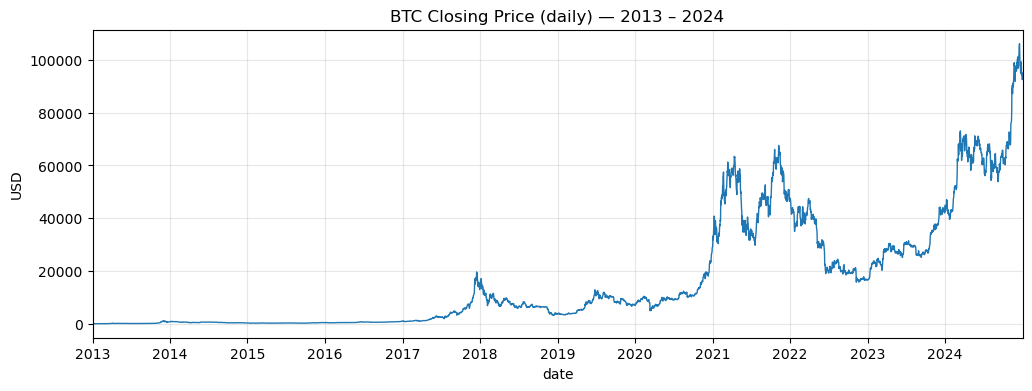

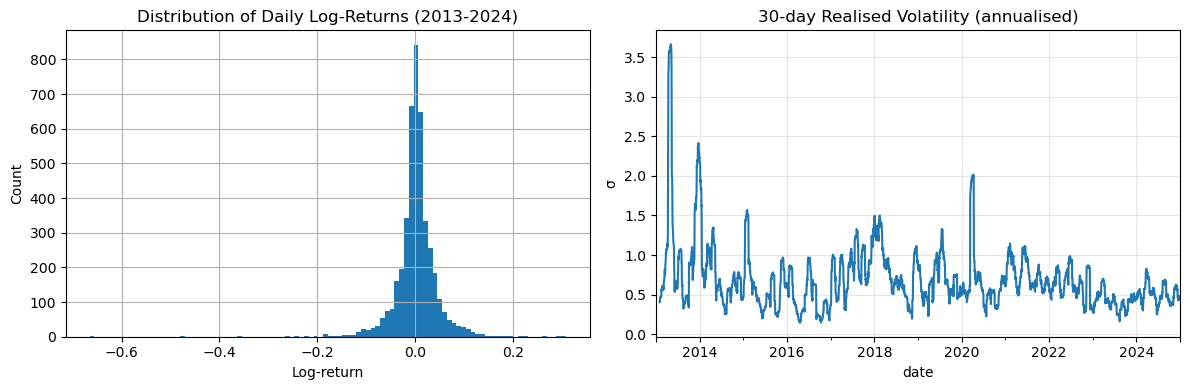

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ------------- focus window ----------------------------------------------
HIST_START, HIST_END = "2013-01-01", "2024-12-31"
df_focus = df.loc[HIST_START:HIST_END].copy()

# ------------- core series ----------------------------------------------
df_focus["close"]   = df_focus["PriceUSD"]

# --- Calculate log_ret and rolling_vol_30d on df_focus ---
df_focus["log_ret"] = np.log(df_focus["close"]).diff()
df_focus["rolling_vol_30d"] = (
    df_focus["log_ret"].rolling(30).std() * np.sqrt(365)
)

# ------------- price with yearly x-ticks ---------------------------------
fig, ax_price_plot = plt.subplots(figsize=(12, 4)) # Renamed ax to avoid conflict
df_focus["close"].plot(ax=ax_price_plot, lw=1)

# ► one tick per calendar year
ax_price_plot.xaxis.set_major_locator(mdates.YearLocator())
ax_price_plot.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax_price_plot.set_xlim(df_focus.index.min(), df_focus.index.max())

ax_price_plot.set_title("BTC Closing Price (daily) — 2013 – 2024")
ax_price_plot.set_ylabel("USD")
ax_price_plot.grid(alpha=0.3)
plt.show()


# ------------- histogram + rolling vol -----------------------------------
# Using a new figure and axes object for the second set of plots
fig_hist_vol, ax_hist_vol = plt.subplots(1, 2, figsize=(12, 4))

df_focus["log_ret"].hist(bins=100, ax=ax_hist_vol[0])
ax_hist_vol[0].set_title("Distribution of Daily Log-Returns (2013-2024)")
ax_hist_vol[0].set_xlabel("Log-return")
ax_hist_vol[0].set_ylabel("Count")

df_focus["rolling_vol_30d"].plot(ax=ax_hist_vol[1])
ax_hist_vol[1].set_title("30-day Realised Volatility (annualised)")
ax_hist_vol[1].set_ylabel("σ")
ax_hist_vol[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Baseline Signal Analysis: Log-Price Z-Score

To effectively normalize Bitcoin's price dynamics over its volatile history, we utilize Z-Scores calculated on the **logarithm of the daily Bitcoin price**. This method accounts for exponential growth and allows for more comparable measures of statistical deviation across different market cycles. These Log-Price Z-Scores serve as a foundational input for our dynamic allocation model.

The Z-Score is calculated as:
$$Z_{\text{log}} = \frac{\text{Current Log(Price)} - \text{Rolling Mean of Log(Price)}}{\text{Rolling Standard Deviation of Log(Price)}}$$

The charts below illustrate Bitcoin's daily price alongside its Log-Price Z-Scores for various lookback windows (30d, 90d, 180d, 365d, and 1461d), segmented into three major market cycles.

### Log-Price Z-Score Visualizations Across Market Cycles

**Cycle 1: 2013-2016: BTC Price & Log-Price Z-Scores**
`Place holder for image`

**Cycle 2: 2017-2020: BTC Price & Log-Price Z-Scores**
`Place holder for image`

**Cycle 3: 2021-2024: BTC Price & Log-Price Z-Scores**
`Place holder for image`


### Interpreting Log-Price Z-Score Signals for Dynamic DCA

The Log-Price Z-Scores across different windows provide signals to modulate daily purchase decisions for the dynamic DCA strategy:

* **Shorter to Medium-Term Windows (30d, 90d, 180d, 365d):**
    * **Red Shaded Areas (Typically Z ≤ -2σ):** These indicate periods where the log-price is statistically low relative to its recent history for that specific window. These are strong signals to **increase daily purchase allocations** above the established baseline. The more negative the Z-score, and the more windows concurrently show this signal, the stronger the buy indication.
    * **Green Shaded Areas (Typically Z ≥ +2σ):** These highlight periods where the log-price is statistically high. These are signals to **significantly reduce daily purchase allocations**, potentially to the mandatory minimum, to preserve capital and avoid buying into overextended conditions.
    * **Neutral Zones (-2σ < Z < +2σ):** In these periods, daily allocations might hover around the established baseline, with minor adjustments based on the Z-score's proximity to the thresholds or its momentum.

* **Long-Term Window (1461d - 4-Year Cycle):**
    * **Broad Red Shaded Area (Z < +1.0, as per your latest highlighting):** This wide zone on the 1461d Z-score chart now signifies any period where the market is *not* in a state of strong positive deviation (i.e., not significantly "hot" or overvalued) relative to its 4-year rolling log-price mean. This suggests a generally permissible environment for baseline accumulation.
        * Within this broad green zone, the *actual level* of the Z-score becomes critical. A Z-score closer to -1.0 or below would indicate a much stronger long-term undervaluation than a Z-score of +0.8.
    * **Green Shaded Area (Presumably Z ≥ +2.0):** This remains a critical signal of potential major market tops or euphoric phases. Allocations should be minimal during these times.
    * **Intermediate Zone (e.g., +1.0 ≤ Z < +2.0):** This zone indicates the market is positively deviated from its long-term mean but not yet at extreme levels. Caution should increase, and baseline allocations might be tapered.

### Strategic Yearly Baseline Allocation using the 4-Year Log-Price Z-Score

The 1461-day Log-Price Z-Score, particularly its value at the **beginning of each calendar year (January 1st)**, can strategically define the *initial baseline budget distribution profile* for that entire year. This sets the overall posture for accumulation before daily dynamic adjustments are made.

**Methodology for Initial Baseline Distribution:**

1.  **Assess Long-Term Market Regime (Jan 1st):** Evaluate the 1461-day Log-Price Z-Score (Z_1461d).
2.  **Define Initial Baseline Profile based on Z_1461d State:**

    * **Deep Undervaluation:**
        * *Indication:* Market is likely in a significant cyclical downturn or bottoming phase. Strongest long-term accumulation opportunity.
        * *Strategic Baseline:* **Aggressively Front-Loaded or Rapidly Increasing Exponential.** The aim is to deploy a larger portion of the annual budget when prices are historically most attractive or as a recovery begins.

    * **Moderate Undervaluation to Neutral:**
        * *Indication:* Market is recovering, consolidating after a fall, or in a neutral phase. Good general accumulation conditions.
        * *Strategic Baseline:* **Uniform Distribution or Moderately Increasing Exponential.** This provides consistent purchasing power with a slight bias towards increasing buys if the trend continues upwards.

    * **Slightly Positive / Early Bullish:**
        * *Indication:* The market is performing positively but not yet in the "caution" zone (based on your Z < +1.0 green highlight). The trend is generally favorable.
        * *Strategic Baseline:* **Uniform Distribution or Slightly Diminishing Exponential.** Maintain steady accumulation, perhaps beginning to exercise a little caution by not overly front-loading.

    * **Caution Zone / Moderately Overvalued:**
        * *Indication:* The market is now outside the broad "green zone" for the 1461d Z-score. Prices are moderately overextended relative to the 4-year mean.
        * *Strategic Baseline:* **Diminishing Exponential or Back-Loaded Uniform.** The baseline allocation starts low and/or decreases, preserving capital for potential corrections or for later in the year.

    * **Strongly Overvalued / Euphoria:**
        * *Indication:* Market is statistically very high, potentially near a major peak.
        * *Strategic Baseline:* **Aggressively Diminishing Exponential or Minimum Allocation Focused.** The baseline daily allocation starts at or very near the mandatory minimum ($1 \times 10^{-5}$). The primary goal is capital preservation.

3.  **Implementing and Maintaining the Baseline:**
    * The chosen baseline profile (uniform, exponential, etc.) and its parameters are set at the start of the year to ensure the sum of these *initial* daily baseline weights equals 1.
    * **Daily Dynamic Adjustments:** Each day, the actual purchase amount will be determined by your model's equation, which takes various features (including these Z-Scores across all windows) as inputs. This equation will generate an adjustment factor to the daily baseline.
    * **Iterative Budget Redistribution:** Crucially, any deviation of the actual daily purchase from the day's *initial baseline value* necessitates a re-calculation/re-scaling of the *initial baseline values* for all remaining days in the year. This dynamic re-balancing ensures the total annual budget constraint (sum of allocations = 1) is strictly adhered to.

This layered approach—using the 4-year Z-score for setting a strategic annual baseline and shorter-term Z-scores (among other features) for daily tactical adjustments—allows the model to be both contextually aware of long-term cycles and responsive to immediate market conditions. The definition of Z_1461d < +1.0 as a generally favorable zone provides a wide window for accumulation, with the specific level within that zone guiding the initial aggressiveness.

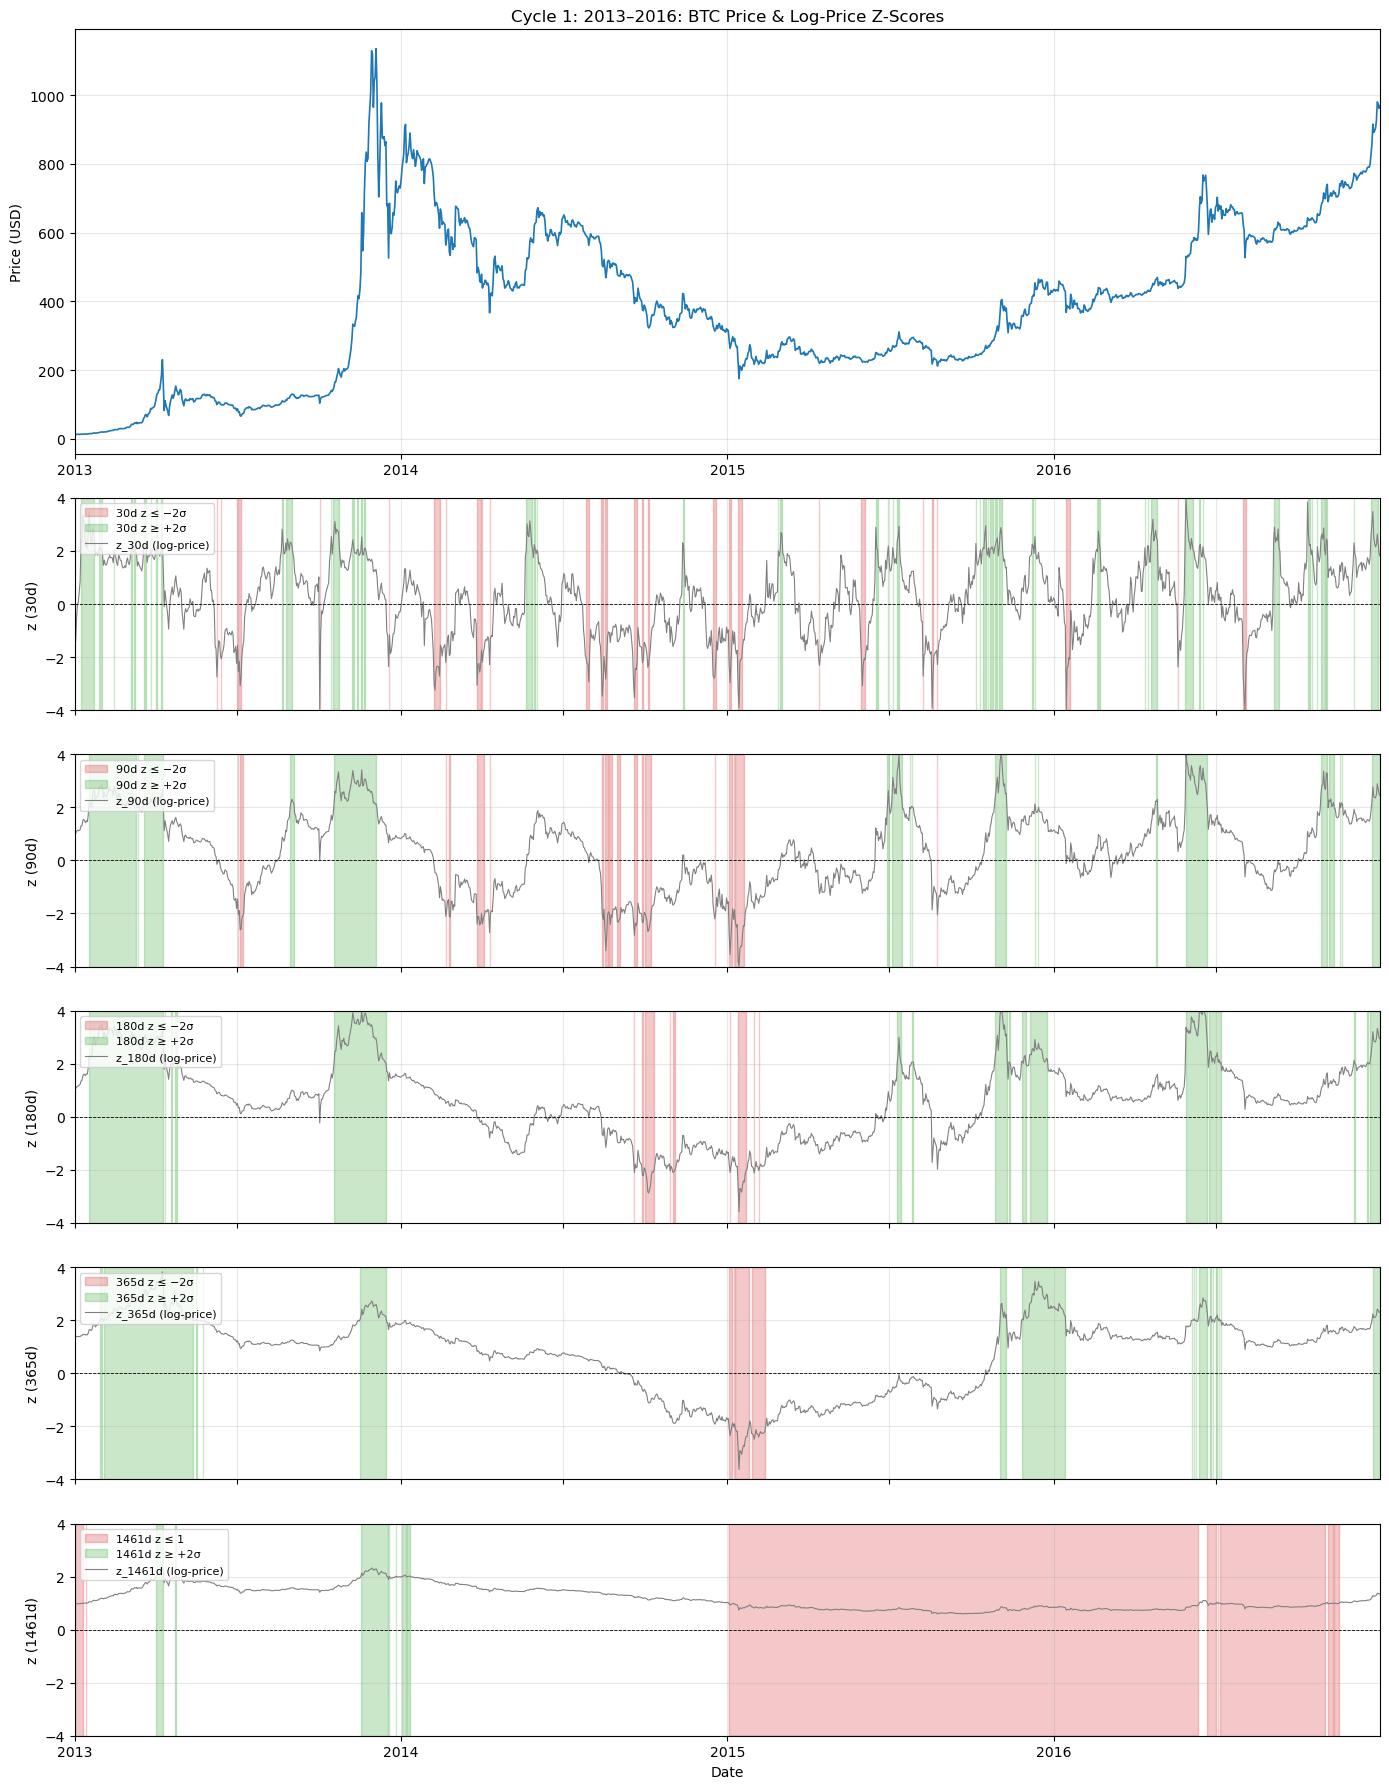

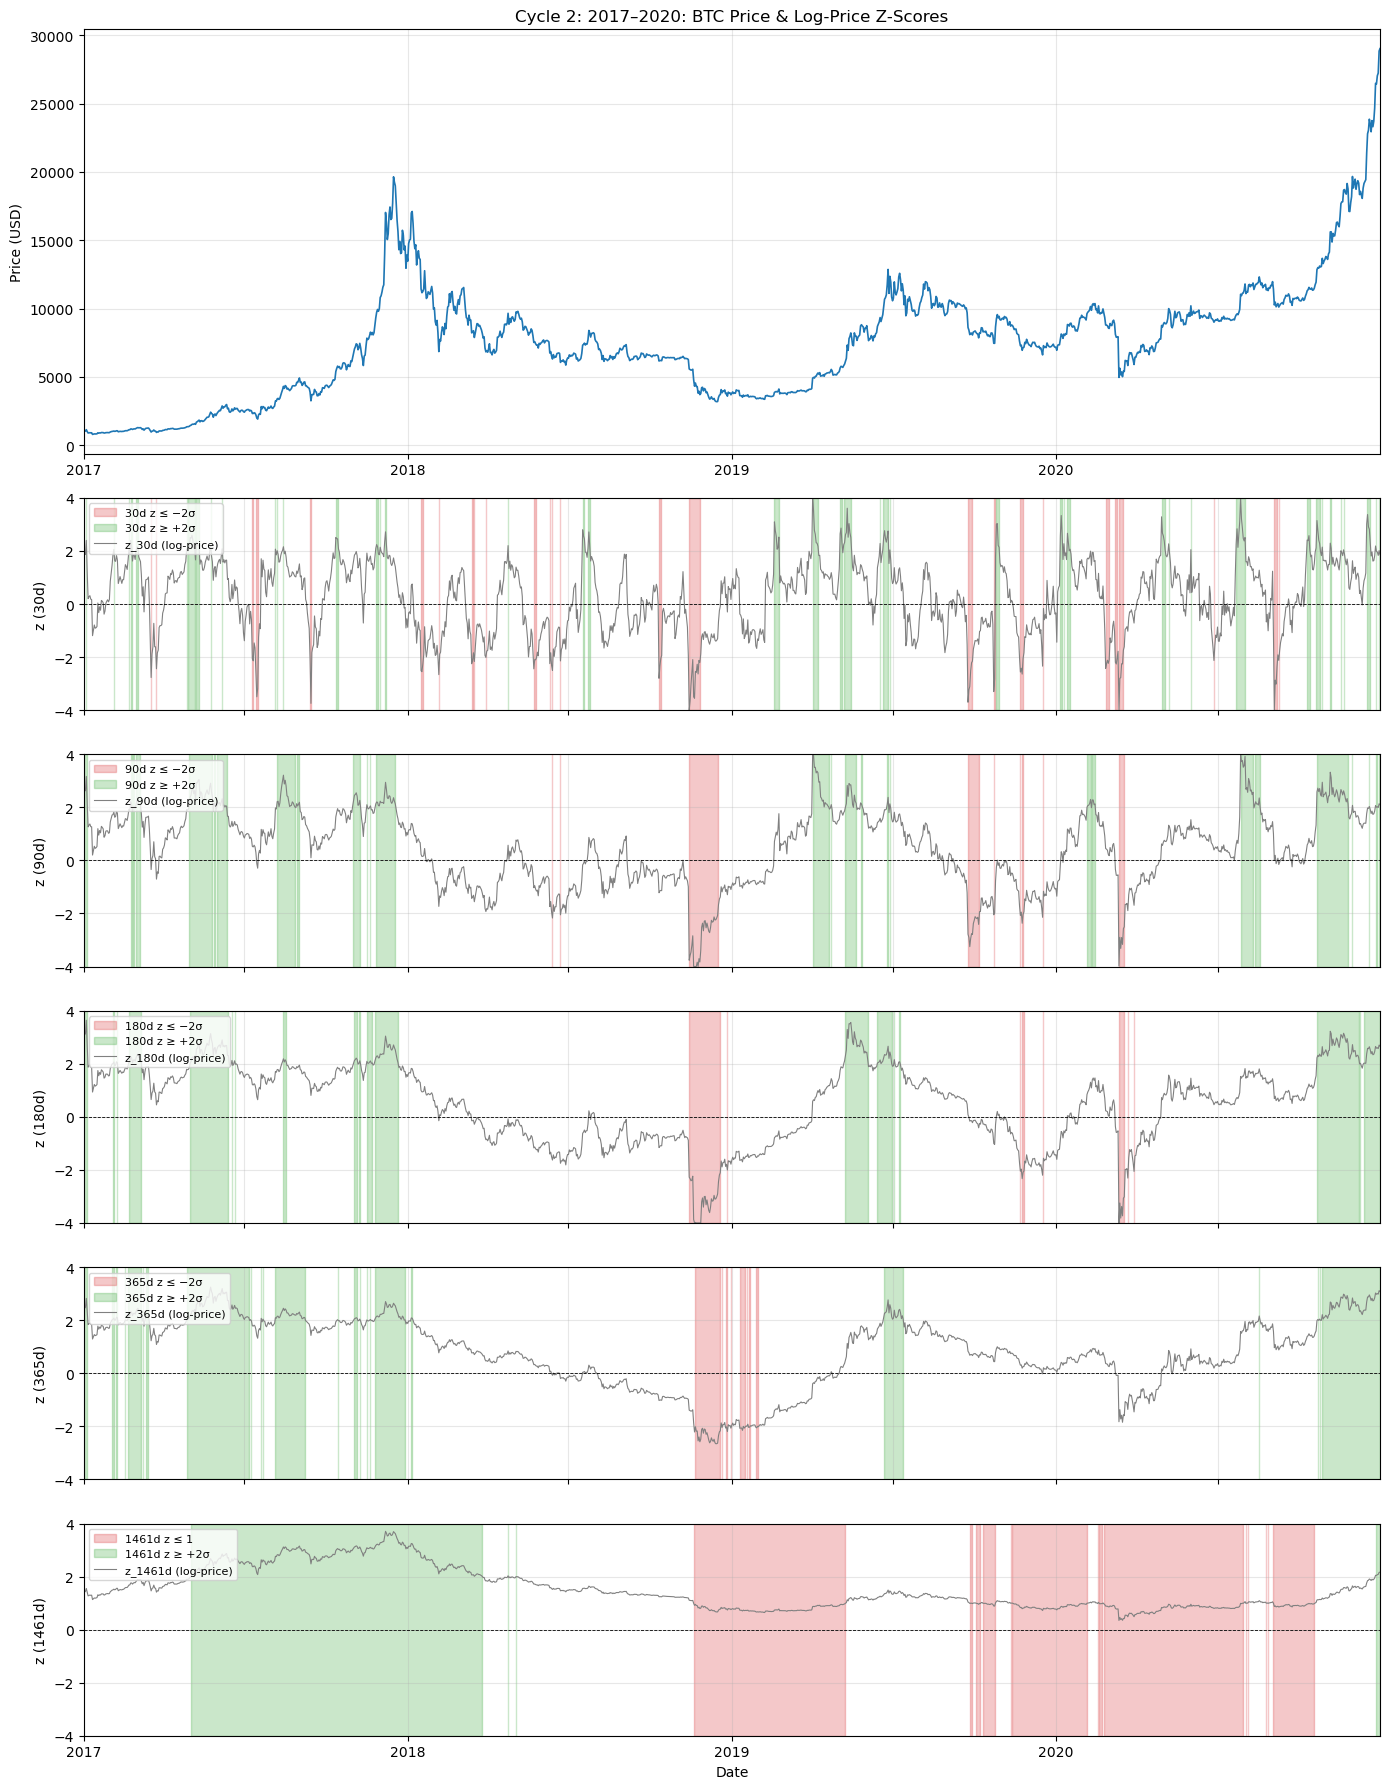

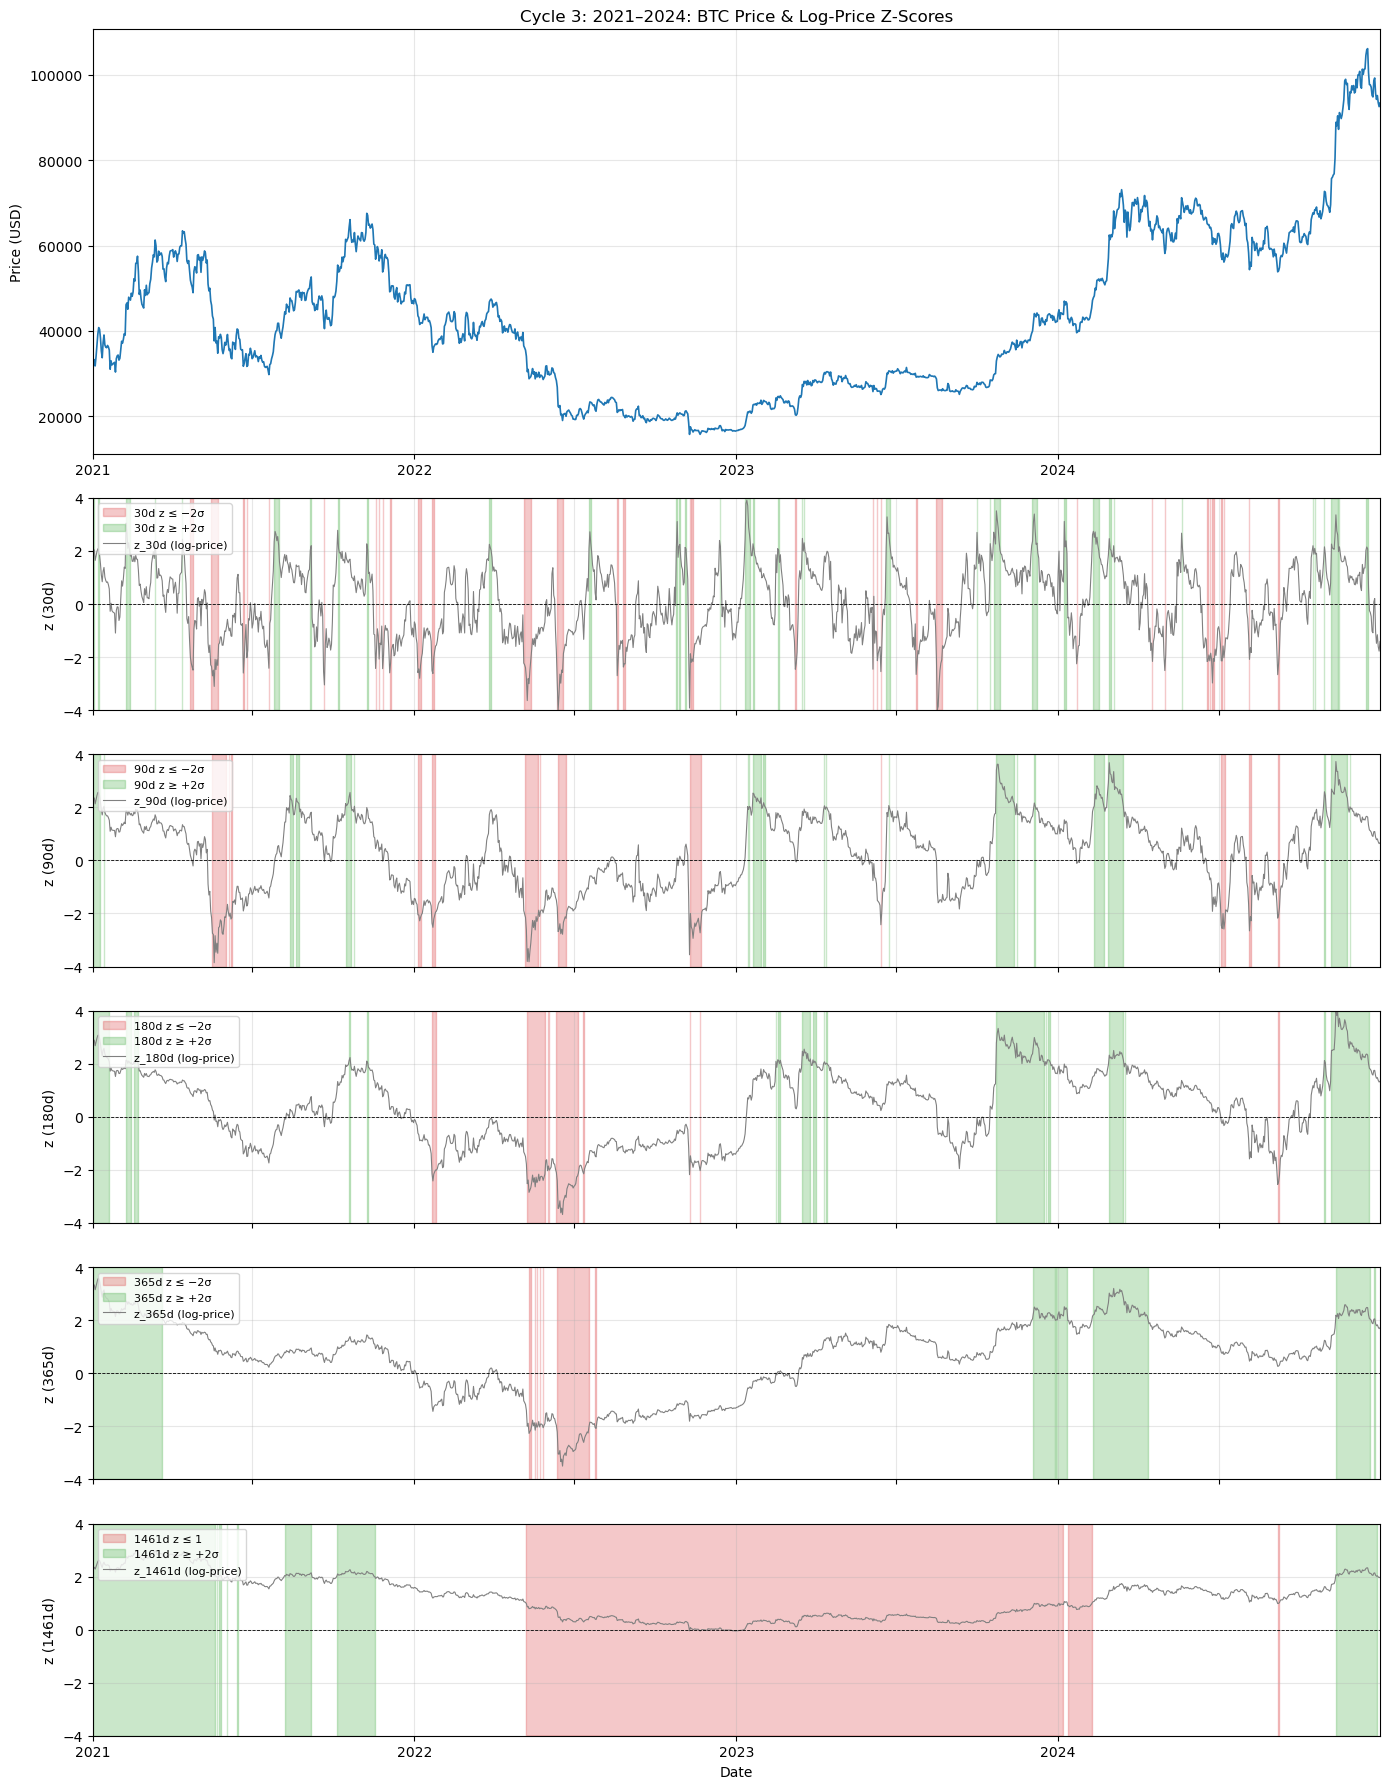

In [26]:
import pandas as pd
import numpy as np # Added for np.log
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Helper for centered rolling z-score
def rolling_zscore(series: pd.Series, window: int) -> pd.Series:
    """
    Compute a trailing rolling z-score of `series` over `window` days,
    using min_periods = window // 2. Returns (series - rolling_mean) / rolling_std.
    """
    rolling_mean = series.rolling(window, min_periods=window // 2).mean()
    rolling_std  = series.rolling(window, min_periods=window // 2).std()
    rolling_std = rolling_std.replace(0, np.nan) 
    z = (series - rolling_mean) / rolling_std
    return z.fillna(0) 


# Extract full-range price series (including pre-2013) if available
price_full_all = df["PriceUSD"] 

log_price_full_all = np.log(price_full_all)

windows = [30, 90, 180, 365, 1461] 

zscore_full = {}
for w in windows:
    z = rolling_zscore(log_price_full_all, w).clip(-4, 4)
    zscore_full[f"z_{w}d"] = z

z_df_full_all = pd.DataFrame(zscore_full, index=log_price_full_all.index)

START, END = "2013-01-01", "2024-12-31" 
price_full = price_full_all.loc[START:END]
z_df_cycle_all = z_df_full_all.loc[START:END]

cycle_bounds = [
    ("2013-01-01", "2016-12-31"),
    ("2017-01-01", "2020-12-31"),
    ("2021-01-01", "2024-12-31"),
]
cycle_labels = ["Cycle 1: 2013–2016", "Cycle 2: 2017–2020", "Cycle 3: 2021–2024"]

for (start_dt, end_dt), label in zip(cycle_bounds, cycle_labels):
    start_ts = pd.to_datetime(start_dt)
    end_ts   = pd.to_datetime(end_dt)

    price_cycle    = price_full.loc[start_dt:end_dt]
    z_df_cycle     = z_df_cycle_all.loc[start_dt:end_dt]

    n_plots = 1 + len(windows)
    fig, axes = plt.subplots(
        n_plots, 1, figsize=(14, 3 * n_plots), sharex=False,
        gridspec_kw={"height_ratios": [2] + [1] * len(windows)}
    )

    ax_price = axes[0]
    ax_price.plot(price_cycle.index, price_cycle.values, color="tab:blue", lw=1.2)
    ax_price.set_ylabel("Price (USD)")
    ax_price.set_title(f"{label}: BTC Price & Log-Price Z-Scores")
    ax_price.set_xlim(start_ts, end_ts)
    ax_price.xaxis.set_major_locator(mdates.YearLocator())
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax_price.grid(alpha=0.3)

    for idx, w in enumerate(windows, start=1):
        ax_z = axes[idx]
        col = f"z_{w}d"
        z_values = z_df_cycle[col]

        # Define default thresholds and labels
        lower_thresh_val = -2.0
        upper_thresh_val = 2.0
        current_lower_label = f"{w}d z ≤ −2σ"
        current_upper_label = f"{w}d z ≥ +2σ"

        # Special thresholds for the 1461-day window ---
        if w == 1461:
            lower_thresh_val = 1.0  # New threshold for green highlight
            current_lower_label = f"{w}d z ≤ 1" # Updated label
            # upper_thresh_val could also be adjusted here if needed
        
        # Green for Z <= lower_thresh_val (potential undervaluation/buy)
        ax_z.fill_between(
            z_values.index, -4, 4, where=z_values <= lower_thresh_val,
            color="tab:red", alpha=0.25, label=current_lower_label
        )
        # Red for Z >= upper_thresh_val (potential overvaluation/sell or hold)
        ax_z.fill_between(
            z_values.index, -4, 4, where=z_values >= upper_thresh_val,
            color="tab:green", alpha=0.25, label=current_upper_label
        )

        ax_z.plot(z_values.index, z_values.values, color="grey", lw=0.8, label=f"z_{w}d (log-price)")
        ax_z.axhline(0, ls="--", c="k", lw=0.6)
        ax_z.set_ylim(-4, 4)
        ax_z.set_ylabel(f"z ({w}d)")
        ax_z.set_xlim(start_ts, end_ts)
        ax_z.grid(alpha=0.3)
        ax_z.legend(loc="upper left", fontsize=8)

        if idx == len(windows): 
            ax_z.set_xlabel("Date")
            ax_z.xaxis.set_major_locator(mdates.YearLocator())
            ax_z.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        else:
            ax_z.set_xticklabels([])
    
    plt.tight_layout()
    plt.show()

## 4. On-Chain Signal: Active Address Momentum (AdrActCnt 90-Day Z-Score)

Beyond price-derived metrics, on-chain data can offer insights into network adoption, user activity, and overall blockchain health. One such metric is the **Active Address Count (`AdrActCnt`)**, which quantifies the number of unique addresses participating in transactions on a given day.

To gauge momentum in network activity, we analyze the 90-day Z-Score of `AdrActCnt`. This tells us if current activity levels are statistically high or low compared to the recent three-month average. To filter out daily noise and identify more persistent trends, we also compute and primarily focus on a **7-day centered moving average (MA) of this 90-day Z-Score**.

### Active Address Momentum Visualizations (Smoothed Highlights)

The charts below display Bitcoin's daily price in the top panel. The bottom panel displays:
* The raw 90-day Z-Score of `AdrActCnt` (light grey line).
* The 7-day MA of this Z-Score (darker grey line, our primary focus for signals).
* Shaded regions based on the **smoothed 7-day MA Z-Score**:
    * **Green areas:** Smoothed Z-Score ≥ +2σ (indicating sustained high network activity).
    * **Red areas:** Smoothed Z-Score ≤ -1.5σ (indicating sustained low network activity).

**Cycle 1: 2013–2016: BTC Price (top) vs AdrActCnt – 90-Day Z-Score (bottom)**
`Place holder for chart`

**Cycle 2: 2017–2020: BTC Price (top) vs AdrActCnt – 90-Day Z-Score (bottom)**
`Place holder for chart`

**Cycle 3: 2021–2024: BTC Price (top) vs AdrActCnt – 90-Day Z-Score (bottom)**
`Place holder for chart`

### Interpreting Active Address Momentum Signals (from Smoothed Z-Score)

Focusing on the 7-day MA of the AdrActCnt Z-Score (dark grey line) and the corresponding shaded regions:

* **Sustained High Activity (Smoothed Z ≥ +2σ, Prominent Green Zones):**
    * These periods indicate significantly elevated and persistent network participation compared to the recent quarterly norm.
    * Visually, these green zones are quite distinct and frequently align with significant price peaks (e.g., late 2013, late 2017, early 2021) or periods of intense bullish rallies where market excitement is high. This suggests that extremely high network activity, as defined by this metric, often characterizes market tops or "heated" conditions.

* **Sustained Low Activity (Smoothed Z ≤ -2σ, Less Prominent Red Zones):**
    * These periods, shaded in red, signify a notable and lasting slowdown in network engagement below a -2 standard deviation threshold.
    * While these red zones can occur during market downturns or consolidation phases, they are generally less frequent and less visually dominant in the provided charts compared to the green zones. They appear to mark specific points of very low activity rather than entire bear phases.

* **Transitions and Trends:** The direction of the smoothed Z-score remains a key aspect. A rise from very low levels (even if not triggering a red zone) or a fall from very high levels (green zones) can provide valuable context about shifts in network participation momentum.

### Value Proposition for Dynamic DCA

The AdrActCnt Z-Score, with its emphasis on high-activity periods in these charts, offers a particular angle for a dynamic DCA model:

* **Relationship with Price Z-Scores: Complementary or Redundant?**
    * **Complementary Aspects:**
        * **Peak Detection/Caution:** The more prominent green zones (Smoothed AdrActCnt Z ≥ +2σ) often coinciding with price peaks offer a strong complementary signal to high Price Z-Scores, reinforcing the case for reducing allocations when the market is euphoric and network activity is exceptionally high.
        * **Divergence Still Relevant:** Bearish divergence (high price, falling AdrActCnt Z) or bullish divergence (low price, rising AdrActCnt Z from low levels) can still be insightful, even if the red "low activity" zones are less broad.
    * **Potential Redundancy:**
        * During periods where price and activity move in very close concert (e.g., a steady, non-euphoric uptrend with gradually increasing activity), the AdrActCnt Z might not add significantly different information than a Price Z-Score tracking the price trend itself.

* **Informing Buy/Reduce Decisions (Daily Modulation):**
    * **Strong Signal to Reduce Buys:** The appearance of a green zone (Smoothed AdrActCnt Z ≥ +2σ) should be a strong signal to significantly reduce daily purchase allocations, potentially to the mandatory minimum. This aligns with avoiding buying into market euphoria often seen near peaks.
    * **Interpreting Low Activity (Red Zones - Smoothed Z ≤ -2σ):** Given their infrequency in the charts, when these *do* appear, they signify exceptionally low network participation. If this coincides with low Price Z-Scores, it could mark a period of extreme apathy or capitulation, which historically can be opportune (though potentially risky) moments for increasing allocations cautiously.
    * **Using the Smoothed Line's Level:** The absolute level of the smoothed AdrActCnt Z-score (dark grey line), even when not in a shaded zone, can be used. For example, if it's trending down sharply from a high level, one might become more conservative even before it hits +2σ again. If it's rising steadily from a low base (e.g., from below -1.0), it could signal returning health.

* **Potential for Misleading Signals:**
    * The primary risk highlighted by these charts is that reducing buys *only* when AdrActCnt Z is in the green zone (≥ +2σ) might still be somewhat late if the peak of activity slightly lags the absolute price peak.
    * Relying on the infrequent red zones (≤ -2σ) as the *sole* contrarian buy signal might mean missing broader periods of undervaluation if network activity doesn't fall to such extreme statistical lows.

* **Refining Initial Yearly Baseline Allocation:**
    * **Start of Year High Activity:** If, at the beginning of the year, the 1461d Price Log-Z-Score already suggests caution (e.g., "Moderately Overvalued" or "Euphoria"), and the 90-day smoothed AdrActCnt Z-Score is also high (e.g., > +1.5σ or in a green zone), this strongly reinforces adopting a very conservative (minimum allocation focused or heavily back-loaded) initial baseline for the year.
    * **Start of Year Low Activity:** If the long-term Price Z-Score suggests undervaluation, and the AdrActCnt Z-Score is exceptionally low (e.g., in a red zone or generally < -1.0), it could further support a more aggressive front-loaded baseline, signaling deep market apathy alongside attractive prices.

### Overall Utility for the Model:

The Active Address Momentum, as visualized with the current highlighting (Smoothed Z ≤ -2σ for red, Smoothed Z ≥ +2σ for green), primarily serves as a **strong indicator of market overheating and euphoria** due to the prominence and correlation of the green zones with price peaks. Its utility for identifying broad "bear market accumulation" zones via the red highlights is less pronounced in these specific charts, making those signals more about pinpointing moments of extreme network quietness.

Therefore, its main role in the dynamic DCA model would likely be:
1.  A strong signal to **reduce buying activity significantly** when network activity reaches exceptionally high Z-scores (green zones).
2.  A **confirmatory signal for accumulation during extreme network lulls** (red zones), provided other indicators (like Price Z-Scores) also suggest undervaluation.
3.  A tool for **detecting divergences** between price and on-chain activity trends.

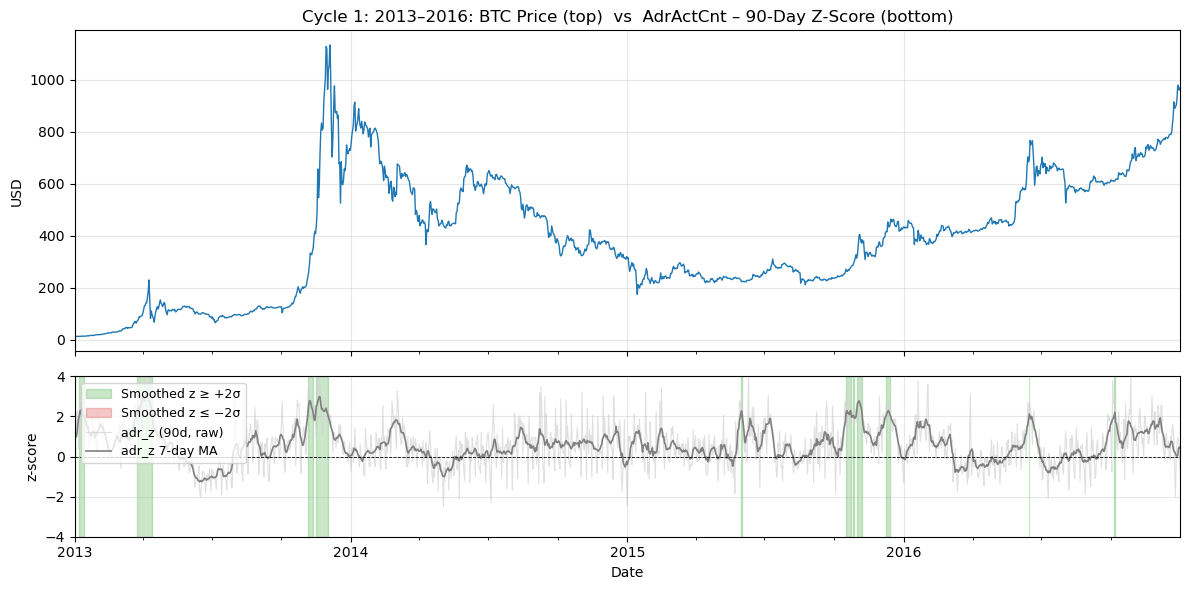

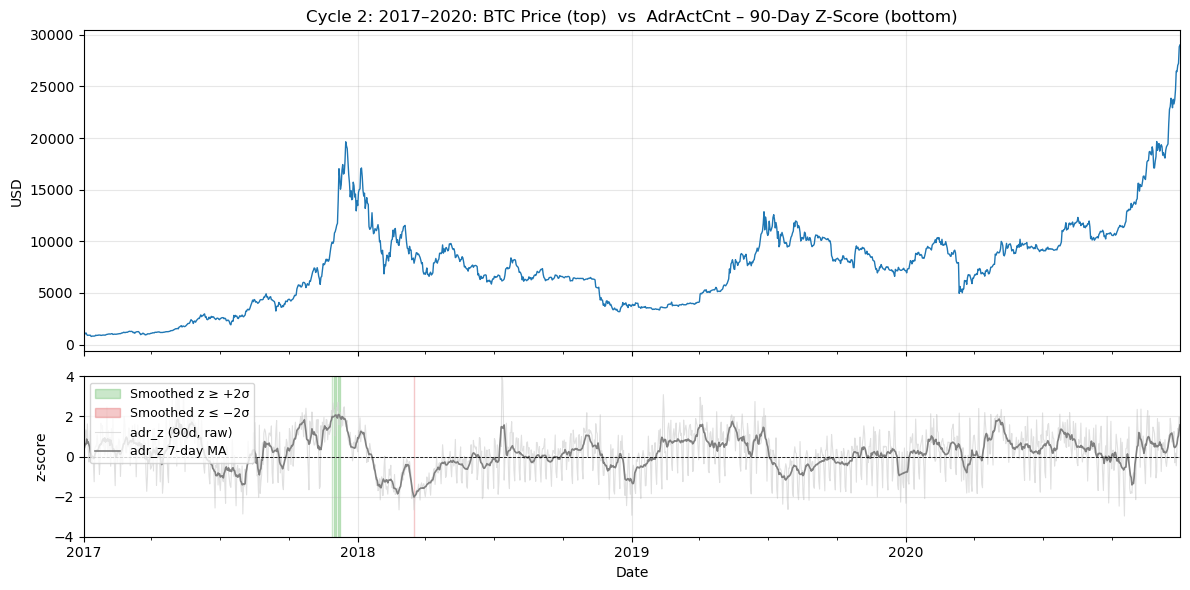

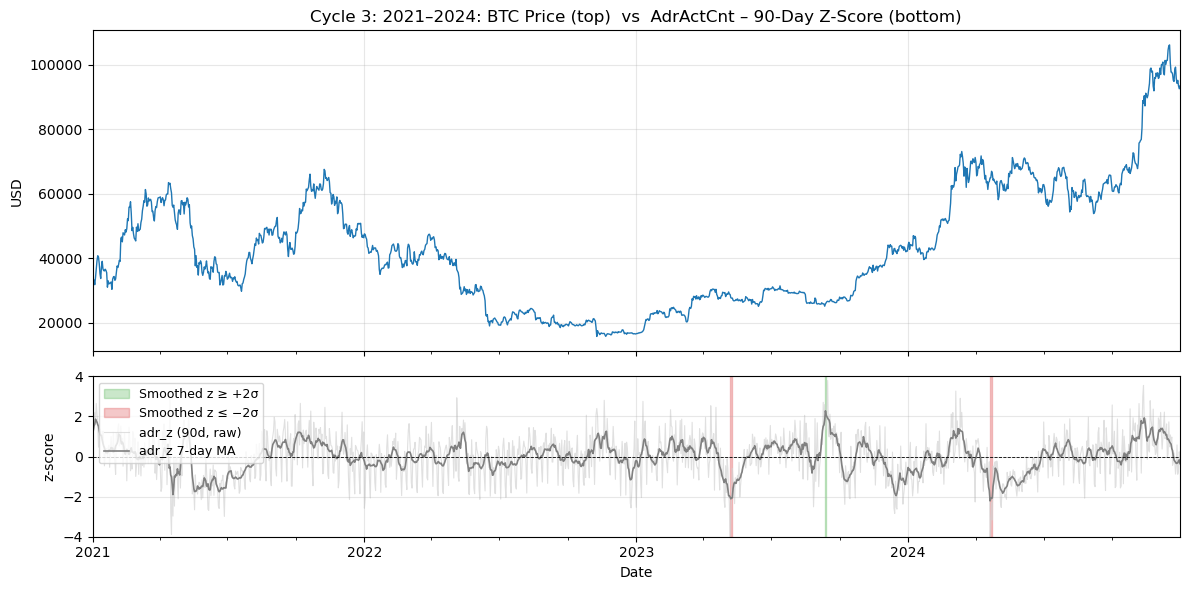

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Helper for centered rolling z-score
def zscore(s: pd.Series, w: int) -> pd.Series:
    """
    Compute centered rolling z-score of series `s` over `w` days,
    using min_periods = w//2 for the rolling window.
    """
    mu = s.rolling(w, w // 2).mean()
    sd = s.rolling(w, w // 2).std()
    # Prevent division by zero or very small std dev
    sd = sd.replace(0, pd.NA) # Replace 0 with NA to avoid division by zero, result will be NA
    z = (s - mu) / sd
    return z.fillna(0) # Fill NaNs that arise from std=0 or initial periods


# Compute the full-range address z-score (2013–2024)
# Ensure AdrActCnt is numeric and handle potential NaNs before zscore calculation
df["AdrActCnt"] = pd.to_numeric(df["AdrActCnt"], errors='coerce')
adr_z_full = zscore(df["AdrActCnt"].dropna(), 90).loc["2013-01-01":"2024-12-31"] # Apply dropna before zscore
price_full = df["PriceUSD"].loc["2013-01-01":"2024-12-31"]

# Reindex adr_z_full to match price_full index to handle any missing dates after dropna
adr_z_full = adr_z_full.reindex(price_full.index).fillna(0)


# Define 4-year cycles
cycle_bounds  = [
    ("2013-01-01", "2016-12-31"),
    ("2017-01-01", "2020-12-31"),
    ("2021-01-01", "2024-12-31"),
]
cycle_labels  = ["Cycle 1: 2013–2016", "Cycle 2: 2017–2020", "Cycle 3: 2021–2024"]

# Loop over each cycle, plotting price (top) and adr_z (bottom) with smoothing
for (start_dt, end_dt), label in zip(cycle_bounds, cycle_labels):
    # Filter data for this cycle
    adr_z_cycle = adr_z_full.loc[start_dt:end_dt]
    price_cycle = price_full.loc[start_dt:end_dt]

    # Compute 7-day centered moving average of the raw z-score for smoothing
    smoothed_adr_z = adr_z_cycle.rolling(window=7, center=True, min_periods=3).mean().fillna(0) # fillna after rolling

    # Create a new figure with two rows (price above, adr_z below)
    fig, (ax_p, ax_a) = plt.subplots(
        2, 1, figsize=(12, 6), sharex=True,
        gridspec_kw={"height_ratios": [2, 1]}
    )

    # Top Panel: BTC Price
    price_cycle.plot(ax=ax_p, lw=1, color="tab:blue")
    ax_p.set_ylabel("USD")
    ax_p.set_title(f"{label}: BTC Price (top)  vs  AdrActCnt – 90-Day Z-Score (bottom)")
    ax_p.xaxis.set_major_locator(mdates.YearLocator())
    ax_p.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax_p.grid(alpha=0.3)

    # Bottom Panel: Address Z-Score with Bold Shading and Smoothing
    ax_a.fill_between(
        smoothed_adr_z.index,
        -4, 4,
        where=smoothed_adr_z >  2,
        color="tab:green", alpha=0.25, zorder=0, label="Smoothed z ≥ +2σ"
    )
    ax_a.fill_between(
        smoothed_adr_z.index,
        -4, 4,
        where=smoothed_adr_z < -2,
        color="tab:red", alpha=0.25, zorder=0, label="Smoothed z ≤ −2σ"
    )

    # Plot raw adr_z line in light grey
    ax_a.plot(
        adr_z_cycle.index, adr_z_cycle.values,
        lw=0.8, color="lightgrey", alpha=0.7, zorder=1, label="adr_z (90d, raw)"
    )
    # Overlay the 7-day MA (smoothed) in dark grey
    ax_a.plot(
        smoothed_adr_z.index, smoothed_adr_z.values,
        lw=1.2, color="grey", label="adr_z 7-day MA"
    )

    ax_a.set_ylim(-4, 4)
    ax_a.axhline(0, ls="--", c="k", lw=0.6)
    ax_a.set_ylabel("z-score")
    ax_a.grid(alpha=0.3)

    # ── X-Axis Formatting ────────────────────────────────────────────────────
    ax_a.set_xlim(pd.to_datetime(start_dt), pd.to_datetime(end_dt))
    ax_a.set_xlabel("Date")
    ax_a.xaxis.set_major_locator(mdates.YearLocator())
    ax_a.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Combine legends
    ax_a.legend(loc="upper left", fontsize=9)

    plt.tight_layout()
    plt.show()

## 5. Network Health Indicators: Hash-Rate & Miner Analysis

This section examines Bitcoin's network operational health through its hash-rate, mining difficulty, and a derived "Miner-Gap ζ" metric. These indicators can offer insights into the robustness and economic conditions of the mining sector, which underpins the network's security.

* **Hash-Rate:** A measure of the total computational power dedicated to mining, reflecting network security and miner investment.
* **Difficulty:** An algorithmically adjusted metric ensuring blocks are found approximately every 10 minutes; it generally follows hash-rate.
* **Miner-Gap ζ (zeta):** This is the 90-day Z-Score of the ratio `HashRate / Difficulty`. This ratio can serve as a rough proxy for miner profitability or operational efficiency (a higher ratio might suggest more hash power is coming online relative to the current difficulty, often favorable for miners).
* **Hash-Rate Z-Score (Hash z):** The 90-day Z-Score of the hash-rate itself, indicating if hash-rate growth is accelerating or decelerating relative to its recent trend.

All Z-Scores are smoothed with a 7-day moving average for clearer signal interpretation, and the highlights in the charts reflect these smoothed values.

### Hash-Rate & Miner Analysis Visualizations

The following charts present a 4-panel dashboard for each market cycle:
1.  **Top Panel:** BTC Price (USD).
2.  **Second Panel:** Raw Hash-Rate and Difficulty on a log scale.
3.  **Third Panel:** Miner-Gap ζ (smoothed 90-day Z-Score of HashRate/Difficulty).
4.  **Fourth Panel:** Hash z (smoothed 90-day Z-Score of HashRate).

For the Z-score panels (3 and 4), highlights are based on the smoothed Z-scores:
* **Green areas:** Smoothed Z-Score ≥ +2σ.
* **Red areas:** Smoothed Z-Score ≤ -2σ.

**Cycle 1: 2013–2016: BTC Price • Hash-Rate & Difficulty • Miner-Gap ζ • Hash z-score**
`Place holder for the chart`

**Cycle 2: 2017–2020: BTC Price • Hash-Rate & Difficulty • Miner-Gap ζ • Hash z-score**
`Place holder for the chart`

**Cycle 3: 2021–2024: BTC Price • Hash-Rate & Difficulty • Miner-Gap ζ • Hash z-score**
`Place holder for the chart`

### Interpreting the Signals

* **Hash-Rate & Difficulty (Row 2):**
    * Both metrics demonstrate a clear, persistent uptrend over the long term, indicating the increasing security and industrialization of Bitcoin mining. Difficulty algorithmically adjusts to hash-rate changes to maintain the target block production rate.

* **Miner-Gap ζ (Smoothed Z-Score of HashRate/Difficulty - Row 3):**
    * **High ζ (Green, Smoothed Z ≥ +2σ):** Indicates the HashRate/Difficulty ratio is statistically high. This scenario suggests favorable conditions for miners, potentially due to hash-rate increasing faster than difficulty can adjust, or significant efficiency gains. Interpreting this as fundamentally bullish, it can be seen as a signal of a healthy, confident mining sector, potentially supporting decisions to accumulate with more conviction. These periods often appear during price uptrends or stable phases where mining remains attractive.
    * **Low ζ (Red, Smoothed Z ≤ -2σ):** Indicates the HashRate/Difficulty ratio is statistically low. This often points to periods of significant miner stress, where profitability is squeezed (e.g., due to falling prices, rising energy costs, or difficulty being too high relative to current hash-rate). These red zones have historically coincided with price bottoms or phases of "miner capitulation" (e.g., visible in late 2018, mid-2021, and late 2022). Such periods can present contrarian buying opportunities.

* **Hash-Rate Z-Score (Smoothed `Hash z` - Row 4):**
    * **High `Hash z` (Green, Smoothed Z ≥ +2σ):** Indicates that hash-rate growth is significantly accelerating compared to its 90-day trend. This signals robust investment and expansion in mining, reflecting miner confidence in future profitability and bolstering network security. Aligned with the view that this reflects a strengthening network, such periods could be interpreted as fundamentally supportive for the price, encouraging accumulation due to underlying network health.
    * **Low `Hash z` (Red, Smoothed Z ≤ -2σ):** Indicates hash-rate growth is significantly decelerating, stagnant, or even declining. This often occurs during sharp price declines that make some mining operations unprofitable, or due to external factors impacting miners. These can signal network stress but also sometimes mark capitulation points near market bottoms, offering potential accumulation opportunities.

### Value Proposition for Dynamic DCA: Usefulness vs. Redundancy

These network health indicators offer a lens into the operational side of Bitcoin. Their utility for a dynamic DCA strategy should be considered against the information already provided by Price Z-Scores, with a particular focus on potential redundancy.

* **Interpreting Green Zones (Z ≥ +2σ) as "Accumulate More Confidently":**
    * Periods of high `Hash z` or high `Miner-Gap ζ` (green zones) can be interpreted as fundamentally bullish for the network's long-term health. For a long-term accumulator, this doesn't necessarily signal that the price is "cheap," but rather that the network's underlying strength is affirming. This robust fundamental backdrop could support decisions to maintain or slightly increase baseline accumulation rates with greater confidence.

* **Why These Indicators Can Be Redundant (Focus):**
    * **Strong Correlation with Long-Term Price Trends:** Bitcoin's price is a primary determinant of miner profitability and, consequently, investment in hash-rate. Over extended periods, a rising price generally incentivizes more hash-rate, leading to higher difficulty. Therefore, major trends in these network metrics are often reactive to, or coincident with, broader price trends. If Price Z-Scores already indicate a strong bull market (e.g., high Log-Price Z-Scores), it's likely that `Hash z` will also be high, and `Miner-Gap ζ` may also reflect favorable conditions. In such scenarios, the Price Z-Score might already provide a sufficient signal for modulating DCA (e.g., reducing buys if the price is indicated as euphoric).
    * **Lagging Nature for Daily Decisions:**
        * Difficulty adjusts roughly every two weeks, meaning the `HashRate/Difficulty` ratio and `Miner-Gap ζ` have an inherent lag in responding to rapid hash-rate changes.
        * Hash-rate itself can sometimes lag significant price movements, particularly on the downside, as miners might delay turning off hardware.
        * For *daily* DCA decisions, these lags could mean that signals from hash-rate related metrics are confirmatory of what price action has already indicated, rather than providing distinct, leading insights for immediate timing.
    * **Complexity vs. Incremental Value for Daily Timing:** While these metrics provide a deeper understanding of network dynamics, incorporating multiple Z-Scores derived from hash-rate (which is itself influenced by price) into a daily allocation equation adds model complexity. If their primary signals regarding market stress or ebullience largely overlap with what can be inferred more directly from Price Z-Scores, their marginal benefit for *precise daily timing* might be limited compared to the directness of price-based indicators.

* **Potential Added Value (Balancing the Perspective):**
    * **Identifying Extreme Miner Stress (Low `Miner-Gap ζ`):** The deep red zones in `Miner-Gap ζ` have historically been potent indicators of miner capitulation. When these periods align with signals of deep undervaluation from Price Z-Scores, they can provide very high-conviction points for more aggressive accumulation.
    * **Gauging Network Resilience:** If the price experiences a sharp correction (low Price Z-Score) but `Hash z` remains strong or recovers quickly, it could suggest underlying network resilience and that the price drop might be more sentiment-driven than a reflection of deteriorating fundamentals. This could support a decision to "buy the dip" with more confidence.

### Overall Utility For Model:

Hash-rate and miner-related Z-Scores are valuable tools for assessing the **fundamental health, security, and economic conditions of the Bitcoin mining network.**

* **Green zones (high Z-scores on these metrics) are fundamentally positive signals encouraging continued or more confident accumulation**. It aligns with investing based on network strength rather than solely on tactical price dips. This could influence the baseline allocation strategy for a given year or the general conviction behind accumulation.
* **Red zones (low Z-scores), particularly for `Miner-Gap ζ`, serve as more classic contrarian indicators,** signaling potential miner capitulation which often precedes significant market recoveries. These are opportunities to "buy when there's blood in the streets," assuming other indicators concur.
* For **daily dynamic DCA decisions, these network health indicators are likely best used as secondary or confirmatory inputs** rather than primary timing signals. Price Z-Scores tend to be more directly reflexive of the immediate market valuation needed for daily purchase modulation.
* The **redundancy** aspect is most prominent during clear, trending markets where price dictates miner behavior predictably. The unique value emerges during **divergences** (e.g., price rising but miner health waning) or at **extreme cycle turning points** (e.g., widespread miner capitulation not yet fully reflected in a price bottom, or extreme network frothiness alongside price euphoria).

**In essence:** while perhaps not the most agile indicators for high-frequency changes in daily allocations, these network metrics are crucial for:
1.  **Confirming market cycle phases** suggested by Price Z-Scores.
2.  Influencing the **strategic annual baseline allocation** by providing a read on fundamental network strength or vulnerability at the start of the year.
3.  Identifying periods of **extreme network stress or euphoria**, which are critical for long-term strategic capital deployment.

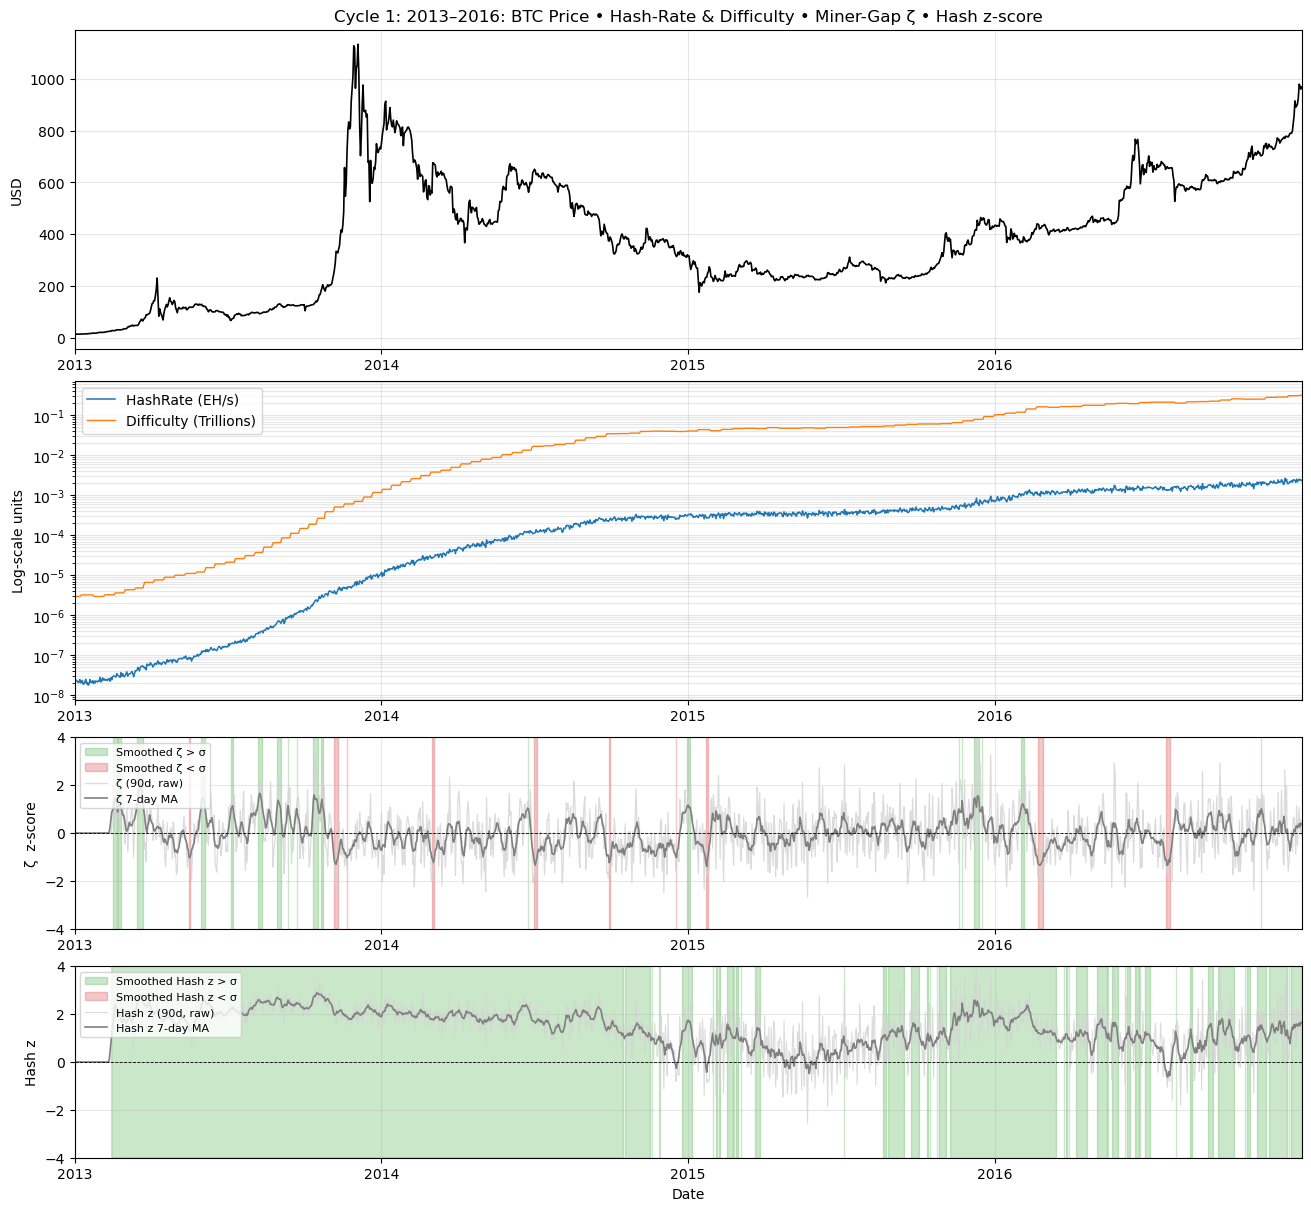

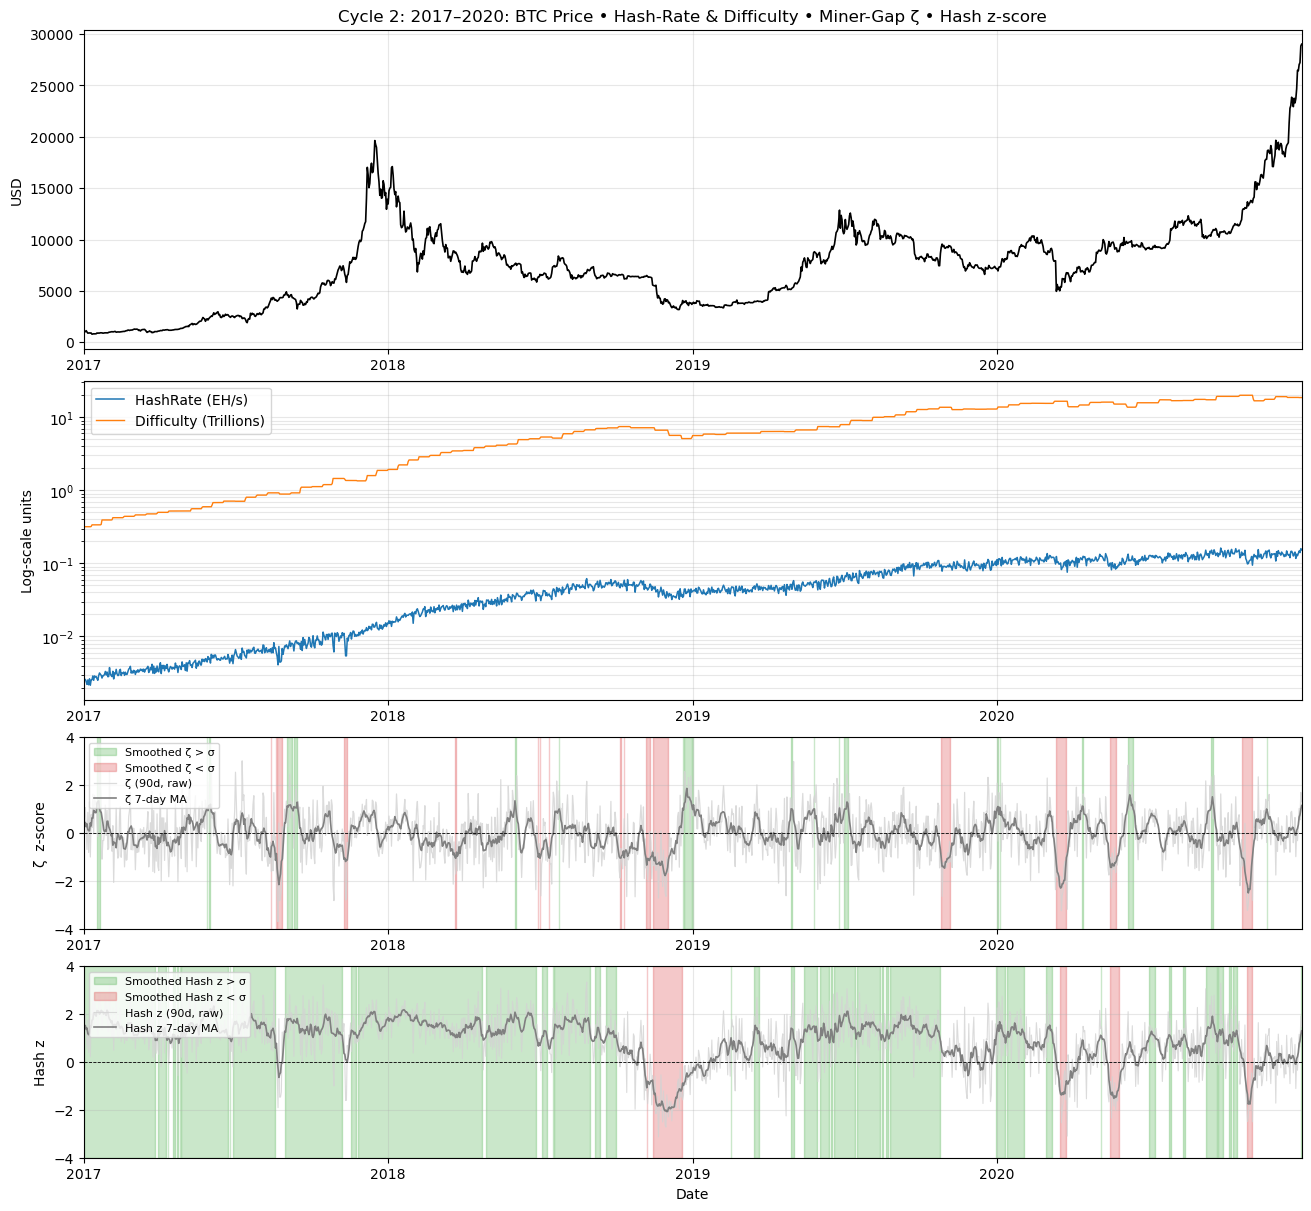

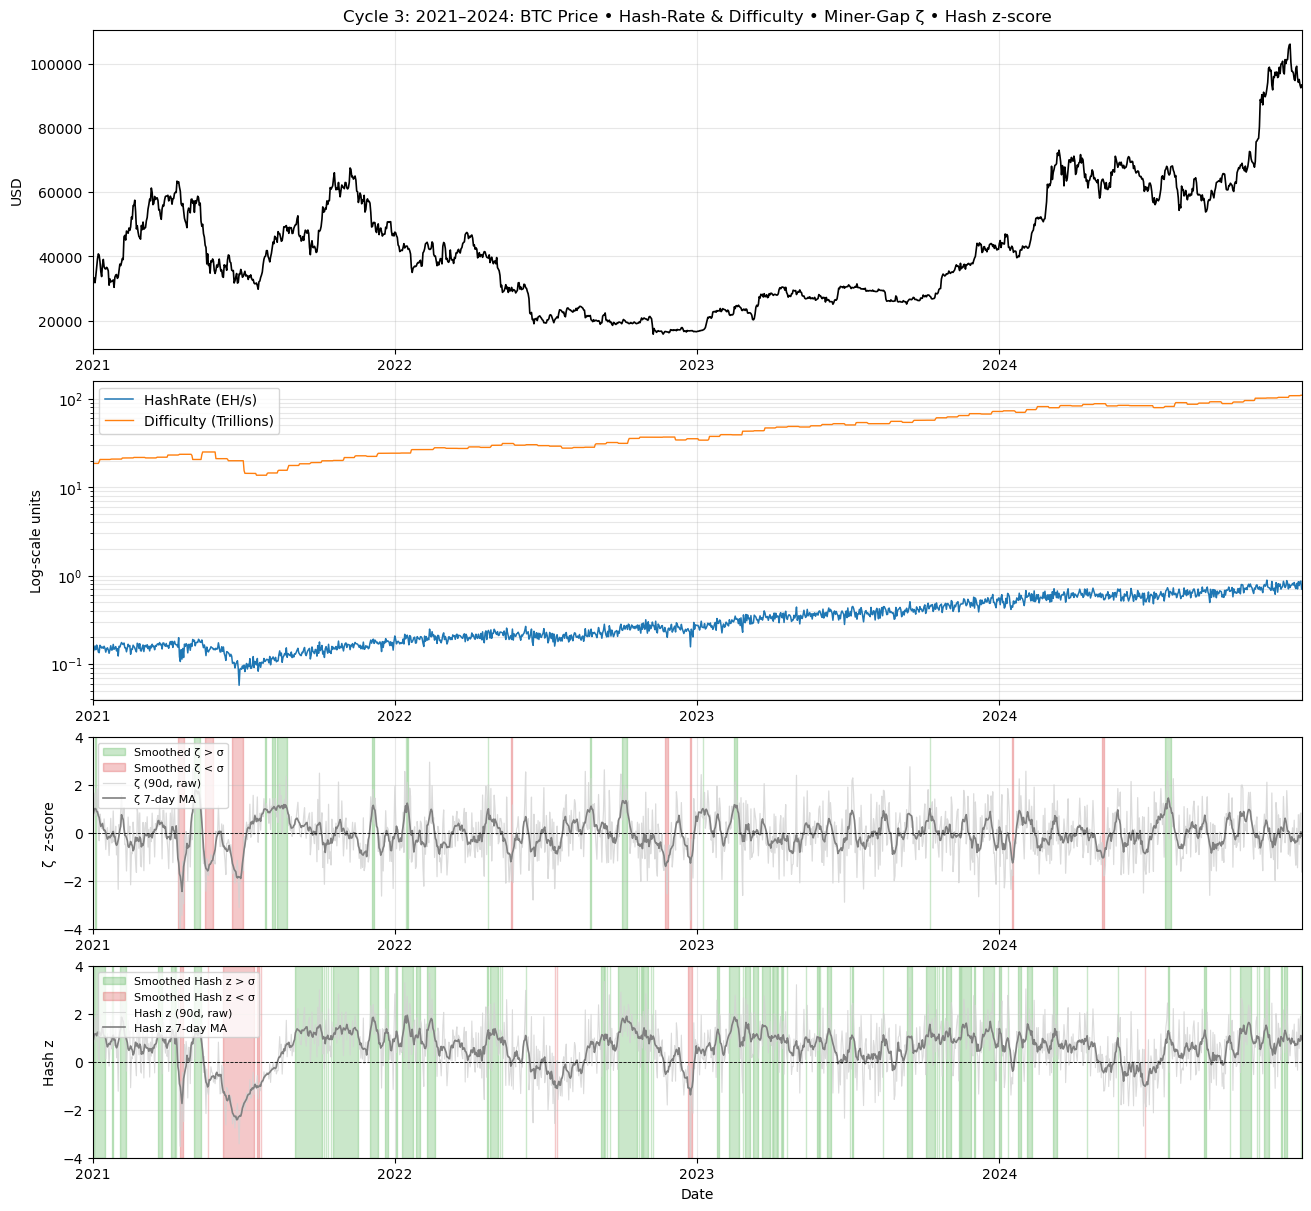

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np # Import numpy for np.nan if not already imported

# Helper for centered rolling z-score
def zscore(s: pd.Series, w: int) -> pd.Series:
    """
    Compute centered rolling z-score of series `s` over a window of `w` days,
    using min_periods = w//2. Returns (s - rolling_mean) / rolling_std.
    """
    rolling_mean = s.rolling(w, w // 2).mean()
    rolling_std  = s.rolling(w, w // 2).std()
    # Prevent division by zero or very small std dev
    rolling_std = rolling_std.replace(0, np.nan) # Use np.nan for division
    z = (s - rolling_mean) / rolling_std
    return z.fillna(0) # Fill NaNs that arise from std=0 or initial periods


# Define full-range series and engineered features (2013-2024)
START, END = "2013-01-01", "2024-12-31"

# Ensure HashRate and DiffMean are numeric, coercing errors
df["HashRate"] = pd.to_numeric(df["HashRate"], errors='coerce')
df["DiffMean"] = pd.to_numeric(df["DiffMean"], errors='coerce')

hash_raw       = df["HashRate"].loc[START:END]
diff_raw       = df["DiffMean"].loc[START:END]
price_full     = df["PriceUSD"].loc[START:END]

# Drop NaNs before division and zscore calculation if any were introduced by coerce
hash_raw_cleaned = hash_raw.dropna()
diff_raw_cleaned = diff_raw.dropna()

# Align indices before division
common_index = hash_raw_cleaned.index.intersection(diff_raw_cleaned.index)
hash_aligned = hash_raw_cleaned.loc[common_index]
diff_aligned = diff_raw_cleaned.loc[common_index]

gap_ratio_full = hash_aligned / diff_aligned
gap_z90_full   = zscore(gap_ratio_full.dropna(), 90).clip(-4, 4) # dropna on ratio before zscore
hash_z90_full  = zscore(hash_raw_cleaned, 90).clip(-4, 4)

# Reindex to the full START:END period to handle any missing dates and fill with 0
gap_z90_full   = gap_z90_full.reindex(price_full.index).fillna(0)
hash_z90_full  = hash_z90_full.reindex(price_full.index).fillna(0)


# Define 4-year cycle boundaries and labels
cycle_bounds  = [
    ("2013-01-01", "2016-12-31"),
    ("2017-01-01", "2020-12-31"),
    ("2021-01-01", "2024-12-31"),
]
cycle_labels  = ["Cycle 1: 2013–2016", "Cycle 2: 2017–2020", "Cycle 3: 2021–2024"]

# Loop over each cycle, plotting a 4-row dashboard
for (start_dt, end_dt), label in zip(cycle_bounds, cycle_labels):
    # Filter data for the current cycle
    price_cycle       = price_full.loc[start_dt:end_dt]
    hash_raw_cycle    = hash_raw.loc[start_dt:end_dt] # Use original hash_raw for plotting raw values
    diff_raw_cycle    = diff_raw.loc[start_dt:end_dt] # Use original diff_raw for plotting raw values
    gap_z90_cycle     = gap_z90_full.loc[start_dt:end_dt]
    hash_z90_cycle    = hash_z90_full.loc[start_dt:end_dt]

    # Compute 7-day centered moving averages of the z-scores
    smoothed_gap_z90  = gap_z90_cycle.rolling(window=7, center=True, min_periods=3).mean().fillna(0)
    smoothed_hash_z90 = hash_z90_cycle.rolling(window=7, center=True, min_periods=3).mean().fillna(0)

    # Create a figure with four subplots
    fig, axes = plt.subplots(
        4, 1, figsize=(13, 12), sharex=False, # sharex=False to allow individual x-axis formatting if needed
        gridspec_kw={"height_ratios": [2, 2, 1.2, 1.2]},
        constrained_layout=True # Helps prevent labels from overlapping
    )

    # Row 1: BTC Price
    ax_price = axes[0]
    ax_price.plot(price_cycle.index, price_cycle.values, lw=1.2, color="black")
    ax_price.set_title(f"{label}: BTC Price • Hash-Rate & Difficulty • Miner-Gap ζ • Hash z-score")
    ax_price.set_ylabel("USD")
    ax_price.set_xlim(pd.to_datetime(start_dt), pd.to_datetime(end_dt))
    ax_price.xaxis.set_major_locator(mdates.YearLocator())
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax_price.grid(alpha=0.3)

    # Row 2: Hash-rate & Difficulty (log scale)
    ax_hd = axes[1]
    ax_hd.plot(hash_raw_cycle.index, hash_raw_cycle / 1e9,  lw=1.1,
               label="HashRate (EH/s)", color="tab:blue")
    ax_hd.plot(diff_raw_cycle.index, diff_raw_cycle / 1e12, lw=1.0,
               label="Difficulty (Trillions)", color="tab:orange")
    ax_hd.set_yscale("log")
    ax_hd.set_ylabel("Log-scale units")
    ax_hd.set_xlim(pd.to_datetime(start_dt), pd.to_datetime(end_dt))
    ax_hd.legend(loc="upper left")
    ax_hd.grid(which="both", alpha=0.3) # Grid for both major and minor ticks on log scale
    ax_hd.xaxis.set_major_locator(mdates.YearLocator())
    ax_hd.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))


    # Row 3: Miner-Gap ζ (raw & smoothed)
    ax_gap = axes[2]
    # Shade based on smoothed_gap_z90 ---
    ax_gap.fill_between(
        smoothed_gap_z90.index, -4, 4, where=smoothed_gap_z90 >  1,
        color="tab:green", alpha=0.25, label="Smoothed ζ > σ"
    )
    ax_gap.fill_between(
        smoothed_gap_z90.index, -4, 4, where=smoothed_gap_z90 < -1,
        color="tab:red",  alpha=0.25, label="Smoothed ζ < σ"
    )
    # Plot raw z-score in light grey
    ax_gap.plot(
        gap_z90_cycle.index, gap_z90_cycle.values,
        lw=0.9, color="lightgrey", alpha=0.8, label="ζ (90d, raw)"
    )
    # Overlay smoothed z-score in dark grey
    ax_gap.plot(
        smoothed_gap_z90.index, smoothed_gap_z90.values,
        lw=1.2, color="grey", label="ζ 7-day MA"
    )
    ax_gap.axhline(0, ls="--", c="k", lw=0.6)
    ax_gap.set_ylim(-4, 4)
    ax_gap.set_ylabel("ζ  z-score")
    ax_gap.set_xlim(pd.to_datetime(start_dt), pd.to_datetime(end_dt))
    ax_gap.legend(loc="upper left", fontsize=8)
    ax_gap.grid(alpha=0.3)
    ax_gap.xaxis.set_major_locator(mdates.YearLocator())
    ax_gap.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Row 4: Hash-rate 90-day z-score (raw & smoothed)
    ax_hz = axes[3]
    # Shade based on smoothed_hash_z90
    ax_hz.fill_between(
        smoothed_hash_z90.index, -4, 4, where=smoothed_hash_z90 >  1,
        color="tab:green", alpha=0.25, label="Smoothed Hash z > σ"
    )
    ax_hz.fill_between(
        smoothed_hash_z90.index, -4, 4, where=smoothed_hash_z90 < -1,
        color="tab:red",  alpha=0.25, label="Smoothed Hash z < σ"
    )
    # Plot raw z-score in light grey
    ax_hz.plot(
        hash_z90_cycle.index, hash_z90_cycle.values,
        lw=0.8, color="lightgrey", alpha=0.8, label="Hash z (90d, raw)"
    )
    # Overlay smoothed z-score in dark grey
    ax_hz.plot(
        smoothed_hash_z90.index, smoothed_hash_z90.values,
        lw=1.2, color="grey", label="Hash z 7-day MA"
    )
    ax_hz.axhline(0, ls="--", c="k", lw=0.6)
    ax_hz.set_ylim(-4, 4)
    ax_hz.set_ylabel("Hash z")
    ax_hz.set_xlim(pd.to_datetime(start_dt), pd.to_datetime(end_dt))
    ax_hz.set_xlabel("Date")
    ax_hz.xaxis.set_major_locator(mdates.YearLocator())
    ax_hz.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax_hz.legend(loc="upper left", fontsize=8)
    ax_hz.grid(alpha=0.3)

    plt.show()

## 6. Valuation Metric: MVRV Ratio & Multi-Window Z-Scores

The MVRV (Market Value to Realized Value) Ratio is a powerful on-chain indicator used to assess Bitcoin's current market price relative to the aggregated cost basis of all coins in circulation. It is calculated as:

**MVRV Ratio = Market Capitalization / Realized Capitalization**

* **Market Capitalization (`CapMrktCurUSD`):** Represents the total current dollar value of Bitcoin's circulating supply.
* **Realized Capitalization (`CapRealUSD`):** Values each Bitcoin at the price it was last transacted on-chain, approximating the total sum paid for all coins by their current holders.

A high MVRV Ratio suggests the market is valued significantly above this aggregate cost basis (potential overvaluation), while a low MVRV Ratio suggests it's valued near or even below it (potential undervaluation).

To assess the statistical extremity of the MVRV Ratio, we use the **MVRV Z-Score**. By employing multiple rolling windows for the Z-Score calculation (30d, 90d, 180d, 365d, 1461d), we can capture valuation dynamics across short-term, medium-term, and long-term (cyclical) perspectives.

### MVRV Analysis Visualizations (Multi-Window)

The following charts display Bitcoin's daily price (top panel) followed by panels showing the MVRV Z-Score calculated using different rolling window lengths. The shaded areas indicate:
* Green: MVRV Z-Score ≥ +2σ (signifying periods where MVRV is statistically high or "Overvalued").
* Red: MVRV Z-Score ≤ -2σ (signifying periods where MVRV is statistically low or "Undervalued").

**Cycle 1: 2013–2016: BTC Price (top) • MVRV Z-Scores (Multiple Windows)**
`Place holder for chart`

**Cycle 2: 2017–2020: BTC Price (top) • MVRV Z-Scores (Multiple Windows)**
`Place holder for chart`

**Cycle 3: 2021–2024: BTC Price (top) • MVRV Z-Scores (Multiple Windows)**
`Place holder for chart`

### Interpreting Multi-Window MVRV Z-Score Signals

The different MVRV Z-Score windows offer distinct insights into market valuation:

* **Short-Term MVRV Z-Scores (e.g., 30d, 90d):**
    * These react quickly to rapid changes in the MVRV ratio.
    * **Red Zones (Z ≤ -2σ):** Can highlight sharp, short-term undervaluation, potentially good tactical dip-buying opportunities if longer-term context is supportive.
    * **Green Zones (Z ≥ +2σ):** Can signal short-term frothiness or local peaks where caution is warranted for new allocations.
    * They tend to be noisier with more frequent signals compared to longer windows.

* **Medium-Term MVRV Z-Scores (e.g., 180d, 365d):**
    * These provide a more stable view of valuation relative to medium-term trends (6-month to 1-year).
    * **Red Zones (Z ≤ -2σ):** Indicate more significant periods of undervaluation, often aligning with extended bear market phases or major corrective bottoms. These are strong signals for increasing DCA allocations. For example, the 365d MVRV Z-Score showed such signals in early 2015, late 2018, and mid-2022.
    * **Green Zones (Z ≥ +2σ):** Highlight periods where the market is significantly overvalued relative to its annual trend, often coinciding with mature bull market stages or cycle tops. These are strong signals to reduce DCA allocations significantly. For example, the 365d MVRV Z-Score showed these conditions in late 2013, late 2017, and early 2021.

* **Long-Term MVRV Z-Score (1461d - 4-Year Cycle):**
    * This indicator provides the broadest perspective on where the current market valuation stands within Bitcoin's long-term, multi-year cycles.
    * **Red Zones (Z ≤ -2σ):** These are rare but historically have pinpointed generational buying opportunities, marking the depths of major bear markets where MVRV is extremely depressed relative to its 4-year mean. Examples include early 2015, late 2018/early 2019, and late 2022.
    * **Green Zones (Z ≥ +2σ):** Also relatively infrequent, these have historically signaled major cycle tops and periods of extreme market euphoria and overvaluation from a long-term perspective. Examples include late 2013/early 2014, late 2017/early 2018, and early 2021.

* **Confluence of Signals:** When multiple MVRV Z-Score windows simultaneously enter extreme zones (e.g., 90d, 180d, and 365d are all red), the signal for undervaluation (or overvaluation if all green) becomes exceptionally strong.

### Value Proposition for Dynamic DCA using Multi-Window MVRV

The multi-window MVRV Z-Score dashboard provides a robust framework for guiding dynamic DCA decisions:

* **Informing Daily Buy/Reduce Decisions:**
    * The model can assign different weights or triggers based on which MVRV Z-Score windows are signaling extremes.
    * For instance, a deep red signal on the 365d MVRV Z-Score might trigger a larger increase in the daily allocation multiplier than a similar signal on only the 30d MVRV Z-Score.
    * Conversely, green signals across multiple longer-term windows would strongly advocate for minimal daily allocations.

* **Enhanced Comparison with Price Z-Scores (Significant Added Value):**
    * While Price Z-Scores indicate if the price is statistically high or low relative to its *own past behavior*, MVRV Z-Scores assess if the market is overvalued or undervalued relative to the *aggregate realized cost basis of its participants*. This is a crucial distinction.
    * MVRV provides a layer of "fundamental" valuation that price momentum oscillators lack. For example, the price might be falling (low short-term Price Z-Score), but if the MVRV Z-Score (especially medium to long-term) is still neutral or high, it suggests the market isn't necessarily "cheap" from a holder valuation perspective.
    * This multi-window MVRV approach provides a rich valuation context across different time scales, which is a more powerful tool than a single MVRV Z-score or Price Z-Scores alone.

* **Strategic Yearly Baseline Allocation:**
    * The state of the **1461d MVRV Z-Score** (and potentially the 365d MVRV Z-Score) at the beginning of each calendar year (January 1st) is an extremely potent input for defining the initial yearly baseline allocation profile:
        * **1461d MVRV Z ≤ -1.5 to -2.0 (Deep Cyclical Undervaluation):** Justifies an **aggressively front-loaded or rapidly increasing exponential** baseline strategy for the year. This aims to deploy significant capital when the market is fundamentally at its cheapest point in a multi-year cycle.
        * **1461d MVRV Z ≥ +1.5 to +2.0 (Deep Cyclical Overvaluation):** Warrants an **extremely conservative baseline** (e.g., minimum daily allocations, heavily back-loaded budget), focusing on capital preservation.
        * **Intermediate States:** Values between these extremes would map to more moderate baseline profiles (e.g., uniform, slightly increasing/decreasing exponential), using the Z-score level to gauge the degree of aggressiveness or caution.

### Overall Utility For Model:

The multi-window MVRV Z-Score analysis provides a comprehensive and robust framework for assessing Bitcoin's market valuation across various time horizons. Its foundation in on-chain economic data (Market Cap vs. Realized Cap) offers a distinct and arguably more fundamental perspective than pure price-based indicators.

For a dynamic DCA strategy, this multi-layered MVRV Z-score system is invaluable. It can:
1.  Provide strong, conviction-based signals for aggressive accumulation during periods of deep, multi-timeframe undervaluation.
2.  Offer clear warnings to significantly reduce or pause accumulation during periods of widespread overvaluation.
3.  Guide the strategic setup of the initial annual allocation baseline, aligning the year's purchasing posture with the broader market cycle context.

Given its historical effectiveness in identifying major market tops and bottoms, a well-interpreted multi-window MVRV Z-Score system is a prime candidate for being a core component of your dynamic allocation model.

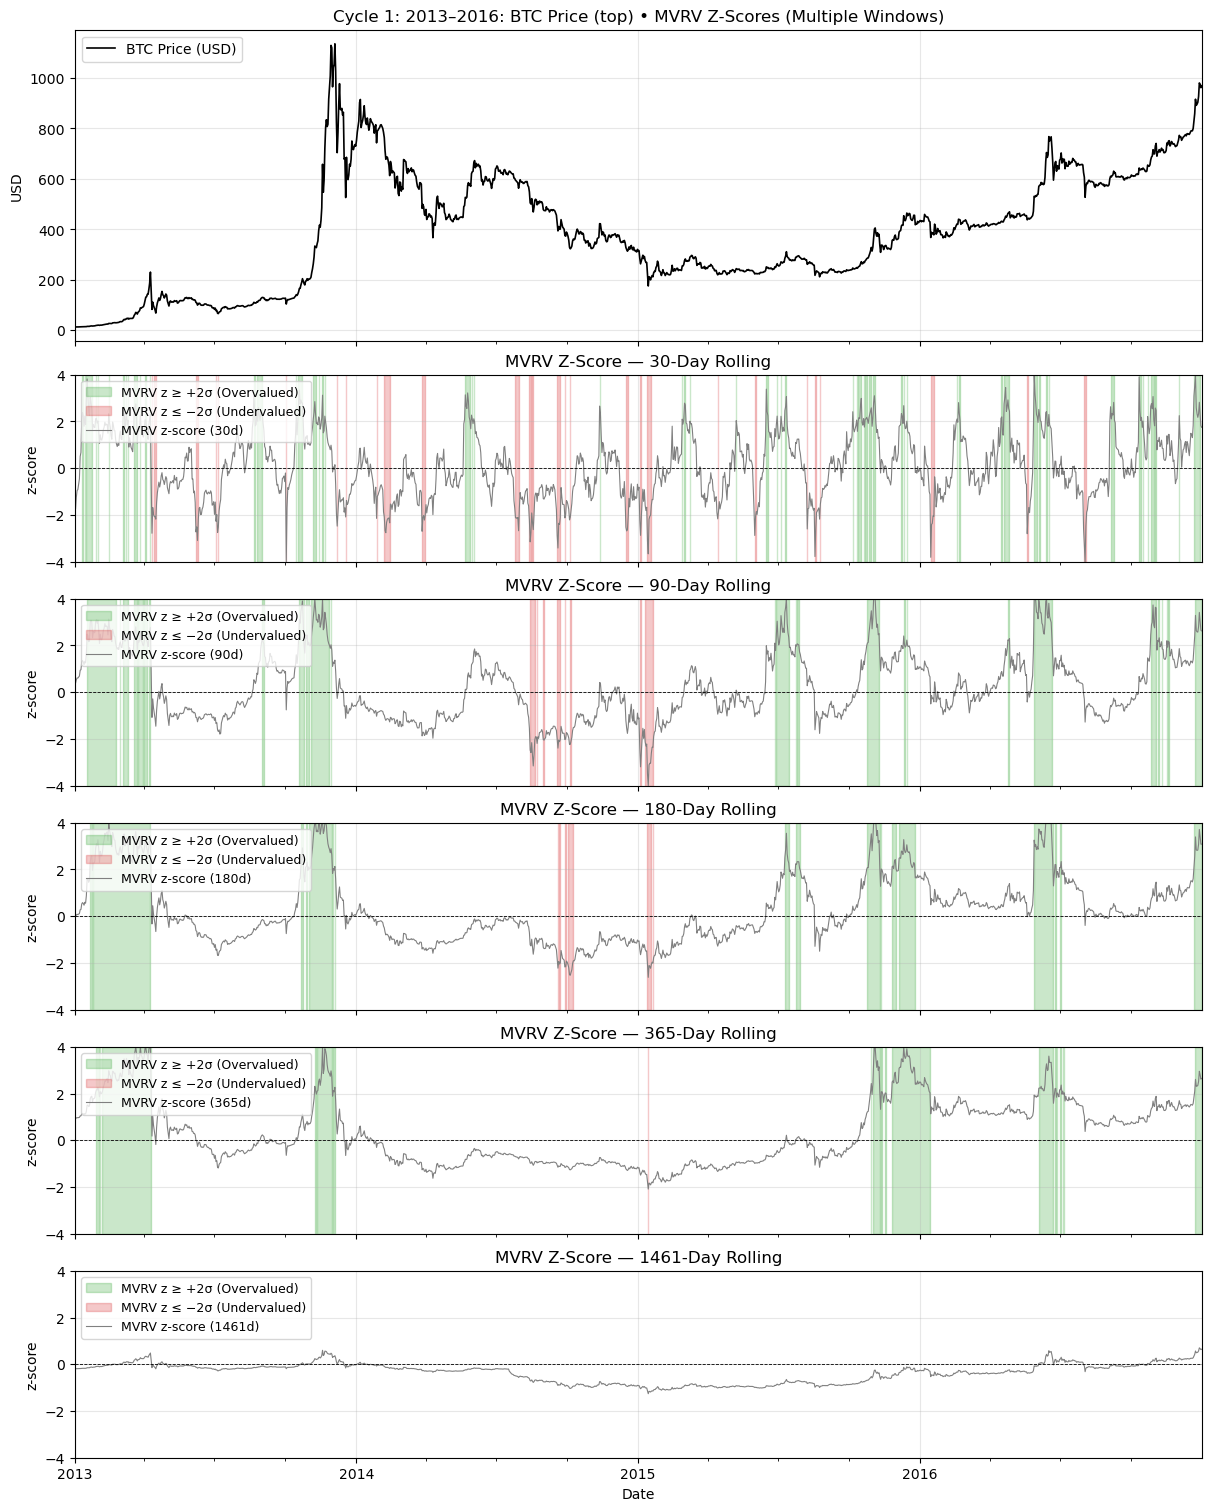

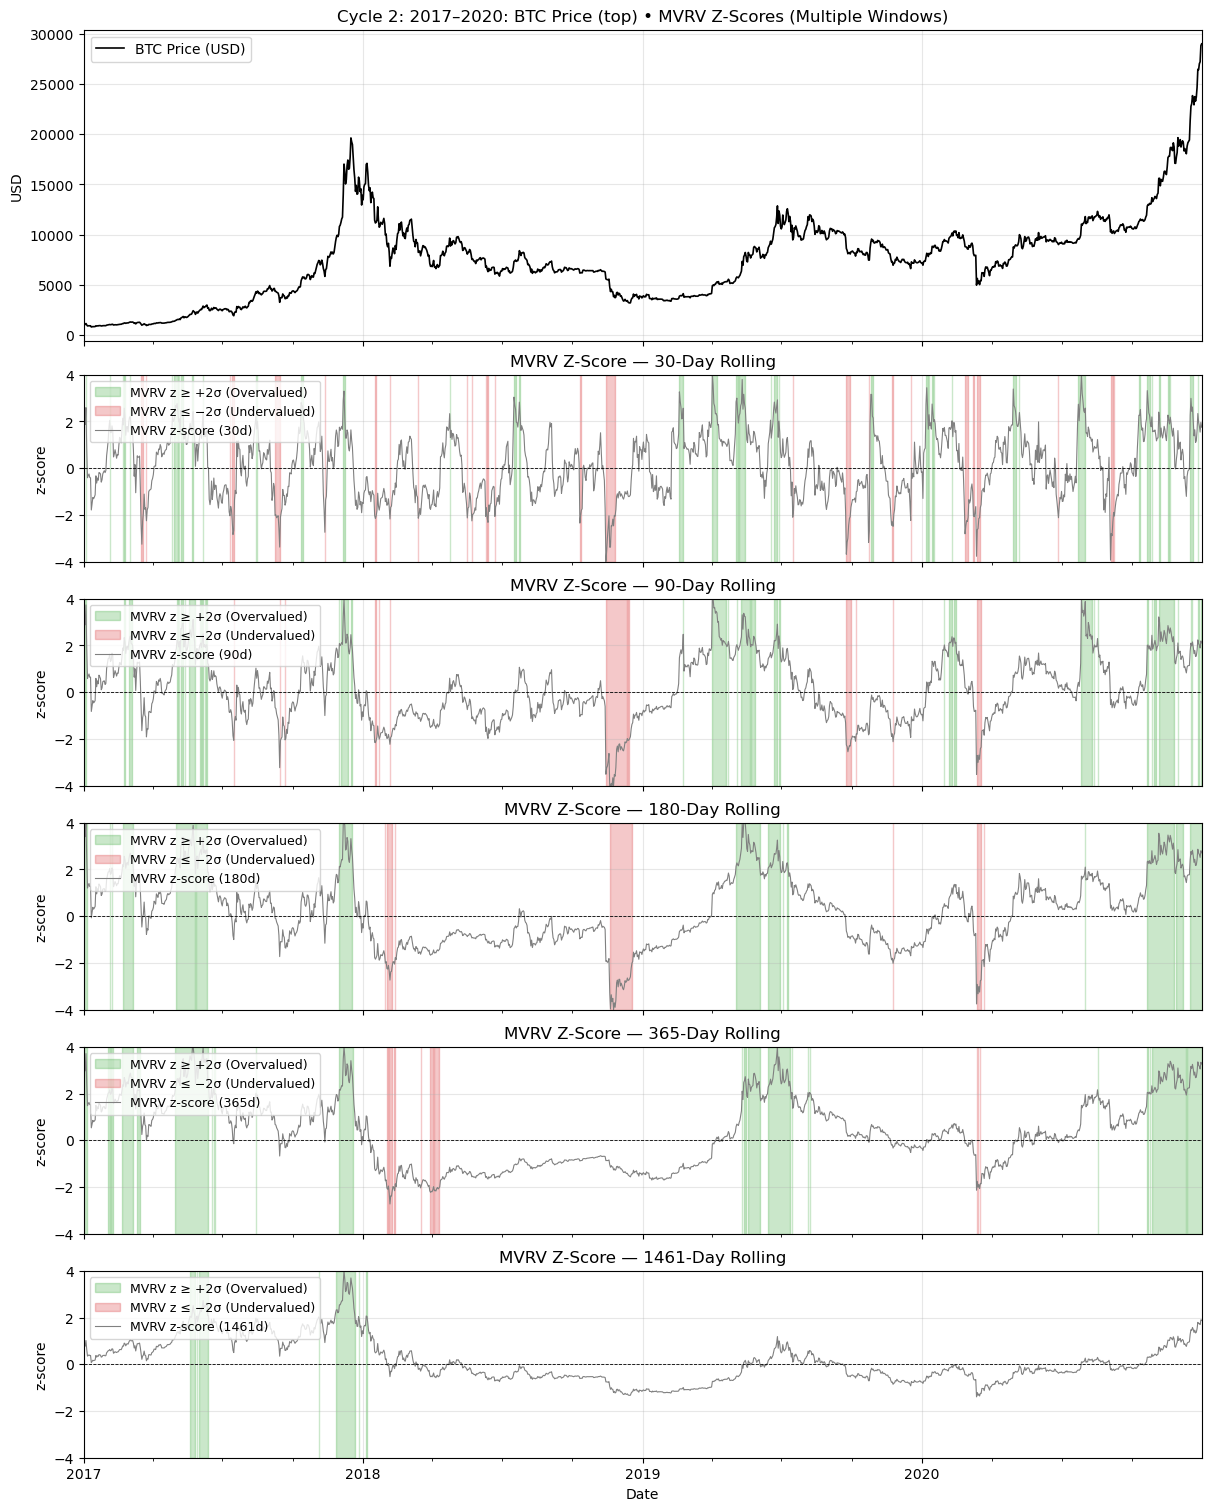

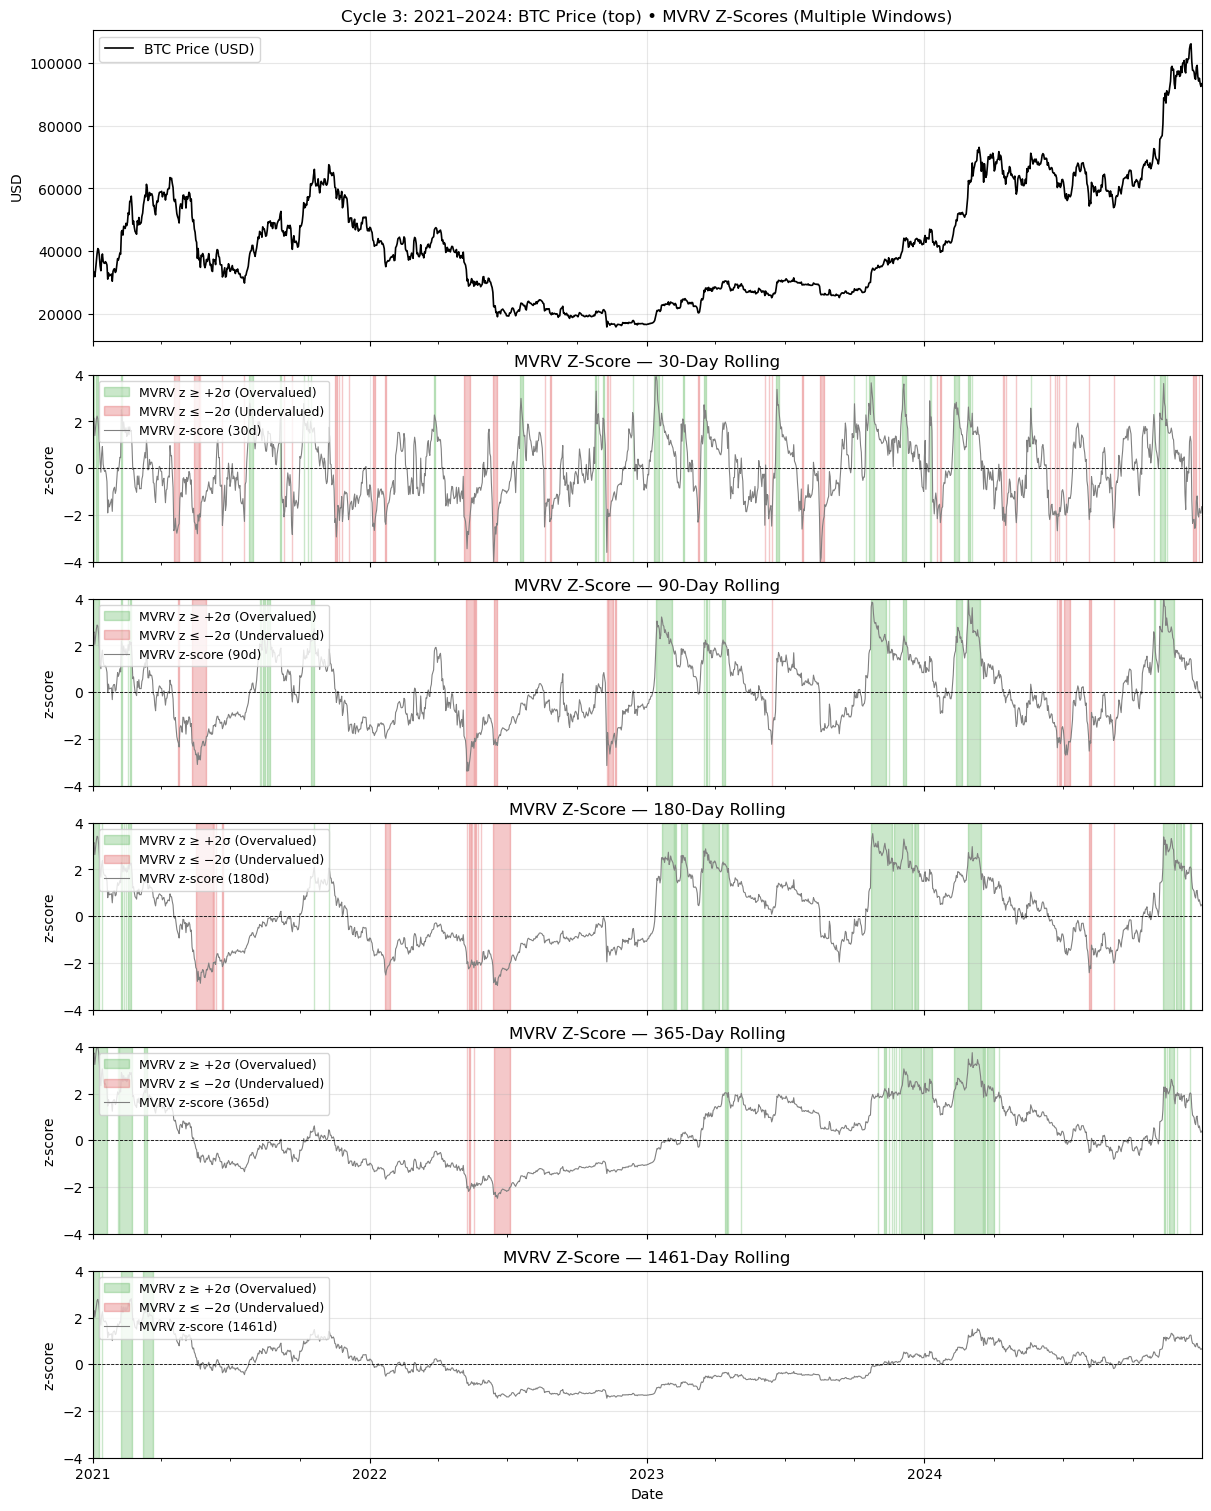

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assume 'df' is your full DataFrame with 'CapMrktCurUSD', 'CapRealUSD', 'PriceUSD'
# and a DatetimeIndex, including data before START if available.

# --- Calculate MVRV and Z-Score on the FULL DataFrame first ---
df["CapMrktCurUSD"] = pd.to_numeric(df["CapMrktCurUSD"], errors='coerce')
df["CapRealUSD"] = pd.to_numeric(df["CapRealUSD"], errors='coerce')

valid_mvrv_mask = (df["CapRealUSD"] > 0) & df["CapRealUSD"].notna() & df["CapMrktCurUSD"].notna()
mvrv_raw_globally = pd.Series(np.nan, index=df.index, dtype=float)
mvrv_raw_globally[valid_mvrv_mask] = df["CapMrktCurUSD"][valid_mvrv_mask] / df["CapRealUSD"][valid_mvrv_mask]
mvrv_raw_globally = mvrv_raw_globally.replace([np.inf, -np.inf], np.nan)

# --- MODIFICATION: Define multiple windows for MVRV Z-Score ---
mvrv_windows = [30, 90, 180, 365, 1461]
# -----------------------------------------------------------

# --- MODIFICATION: Calculate MVRV Z-Scores for each window globally ---
mvrv_z_scores_globally = {}
for window in mvrv_windows:
    roll_mean_global = mvrv_raw_globally.rolling(window, min_periods=window // 2).mean()
    roll_std_global  = mvrv_raw_globally.rolling(window, min_periods=window // 2).std().replace(0, np.nan)
    mvrv_z_w_globally = ((mvrv_raw_globally - roll_mean_global) / roll_std_global).fillna(0).clip(-4, 4)
    mvrv_z_scores_globally[f"mvrv_z{window}d"] = mvrv_z_w_globally

df_mvrv_z_globally = pd.DataFrame(mvrv_z_scores_globally, index=df.index)
# --------------------------------------------------------------------

# Now, slice the globally calculated series for your analysis window
START, END = "2013-01-01", "2024-12-31"
price_full     = df["PriceUSD"].loc[START:END]
# mvrv_raw_full is not strictly needed if histogram is removed, but kept for consistency
mvrv_raw_full  = mvrv_raw_globally.loc[START:END]
df_mvrv_z_full = df_mvrv_z_globally.loc[START:END] # DataFrame of all MVRV Z-scores for the period

# Define 4-year cycle boundaries and labels
cycle_bounds = [
    ("2013-01-01", "2016-12-31"),
    ("2017-01-01", "2020-12-31"),
    ("2021-01-01", "2024-12-31"),
]
cycle_labels = ["Cycle 1: 2013–2016", "Cycle 2: 2017–2020", "Cycle 3: 2021–2024"]

# Loop over each cycle, plotting a multi-row layout
for (start_dt, end_dt), label in zip(cycle_bounds, cycle_labels):
    start_ts = pd.to_datetime(start_dt)
    end_ts   = pd.to_datetime(end_dt)

    price_cycle    = price_full.loc[start_dt:end_dt]
    df_mvrv_z_cycle = df_mvrv_z_full.loc[start_dt:end_dt]

    # --- MODIFICATION: Adjust figure layout (removed histogram plot) ---
    num_mvrv_plots = len(mvrv_windows)
    n_total_plots = 1 + num_mvrv_plots # Price + MVRV Zs
    height_ratios = [2] + [1.2] * num_mvrv_plots # Ratios for Price and MVRV Z-score plots
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 2.5 * n_total_plots)) # Adjusted height
    gs  = fig.add_gridspec(n_total_plots, 1, height_ratios=height_ratios)
    # ----------------------------------------------------------------------

    # Row-1: BTC Price
    ax_price = fig.add_subplot(gs[0, 0])
    price_cycle.plot(ax=ax_price, lw=1.2, color="black", label="BTC Price (USD)")
    ax_price.set_ylabel("USD")
    ax_price.set_title(f"{label}: BTC Price (top) • MVRV Z-Scores (Multiple Windows)")
    ax_price.legend(loc="upper left")
    ax_price.grid(alpha=0.3)
    ax_price.set_xlim(start_ts, end_ts)
    ax_price.xaxis.set_major_locator(mdates.YearLocator())
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax_price.get_xticklabels(), visible=False) # Hide x-ticks as plots are below

    # --- MODIFICATION: Loop to create MVRV Z-Score subplots ---
    shared_ax = ax_price # First MVRV Z plot shares x-axis with Price
    for i, window in enumerate(mvrv_windows):
        ax_z = fig.add_subplot(gs[1 + i, 0], sharex=shared_ax)
        mvrv_z_w_cycle = df_mvrv_z_cycle[f"mvrv_z{window}d"]

        ax_z.fill_between(
            mvrv_z_w_cycle.index, -4, 4,
            where=mvrv_z_w_cycle >= 2,
            color="tab:green", alpha=0.25, label=f"MVRV z ≥ +2σ (Overvalued)"
        )
        ax_z.fill_between(
            mvrv_z_w_cycle.index, -4, 4,
            where=mvrv_z_w_cycle <= -2,
            color="tab:red", alpha=0.25, label=f"MVRV z ≤ −2σ (Undervalued)"
        )
        mvrv_z_w_cycle.plot(ax=ax_z, lw=0.8, color="grey", label=f"MVRV z-score ({window}d)")
        ax_z.axhline(0, ls="--", c="k", lw=0.6)
        ax_z.set_ylim(-4, 4)
        ax_z.set_ylabel("z-score")
        ax_z.set_title(f"MVRV Z-Score — {window}-Day Rolling")
        ax_z.legend(loc="upper left", fontsize=9)
        ax_z.grid(alpha=0.3)
        
        if i < num_mvrv_plots - 1: # If not the last MVRV Z-score plot
            plt.setp(ax_z.get_xticklabels(), visible=False)
        else: # Last MVRV Z-score plot, show x-axis labels
            ax_z.set_xlabel("Date") # Add x-label to the bottom-most plot
            plt.setp(ax_z.get_xticklabels(), visible=True, rotation=0)
            ax_z.xaxis.set_major_locator(mdates.YearLocator())
            ax_z.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
            
    plt.show()

## 7. Synthesizing Insights: Defining the Core Model Features & Strategy Framework

Our exploratory data analysis has examined several categories of indicators: raw price dynamics, Price & Log-Price Z-Scores across multiple windows, on-chain activity via Active Address Momentum, network health through Hash-Rate & Miner-Gap analysis, and fundamental valuation using MVRV Z-Scores. Each offers a unique lens on market conditions, but for a robust and adaptable dynamic DCA model, we need to identify the most potent and reliable signals.

---
### The Primacy of Multi-Window Log-Price Z-Scores

After reviewing the various indicators, the **multi-window Log-Price Z-Score** emerges as the most compelling foundational feature set for our dynamic DCA model. Here’s why:

1.  **Comprehensive Signal Generation:** The Log-Price Z-Scores, particularly when analyzed across different timeframes (e.g., 30d, 90d, 180d, 365d, 1461d), inherently capture a significant amount of the information that other, more complex on-chain metrics attempt to elucidate.
    * Periods of extreme network activity, miner stress or euphoria, and even shifts in broader market valuation (like those indicated by MVRV) ultimately manifest in price action. Price movements are the aggregate result of all market participants' actions, beliefs, and reactions to underlying fundamental shifts.
    * By analyzing the statistical deviations of log-price from its own rolling norms across multiple scales, we directly tap into how the market is pricing itself relative to its recent and long-term history. Extreme Z-Scores often coincide with the signals from other indicators (e.g., a low 365d Log-Price Z-Score often aligns with low MVRV Z-Scores).

2.  **Robustness for Future, Unknown Cycles:**
    * The crypto market is continually evolving. Strategies that rely heavily on specific on-chain relationships or inefficiencies observed in past cycles might become less effective as the market matures, becomes more efficient, and attracts more sophisticated participants (including algorithmic traders and bots that quickly arbitrage away clear inefficiencies).
    * **Price, however, will always be the ultimate arbiter.** It is the direct output of all buying and selling pressures, regardless of whether those pressures are driven by retail sentiment, institutional flows, cyclical patterns, fundamental developments, or automated trading.
    * A strategy anchored in understanding and reacting to the statistical behavior of price itself (via Log-Price Z-Scores) is arguably more **future-proof**. It adapts to how the market *is* behaving, rather than relying on potentially transient correlations with secondary metrics. Future cycles may differ significantly in their on-chain characteristics, but price will always reflect the collective market judgment.

3.  **Direct Application to Allocation:** Log-Price Z-Scores provide a direct, quantifiable measure of how "stretched" the price is. This numerical output can be more straightforwardly incorporated into a mathematical equation for dynamic daily allocation adjustments compared to some more qualitative or complex multi-metric signals.

---
### Role of Complementary Indicators

While the Log-Price Z-Score will be central, selected complementary indicators can still add value, primarily as **confirmatory signals or for defining extreme market states**:

* **MVRV Z-Score (Multi-Window):** Remains highly valuable for identifying deep cyclical undervaluation or extreme overvaluation from a fundamental "cost basis" perspective. Its state, particularly for longer windows (365d, 1461d), can strongly influence the initial yearly allocation profile or add conviction to signals from Price Z-Scores.
* **Miner-Gap ζ or other Miner Health Indicators:** Extreme readings can flag periods of miner capitulation (strong buy signal if Price/MVRV also low) or unsustainable mining euphoria (caution signal).

These should likely act as secondary or tertiary inputs, perhaps influencing the *aggressiveness* of the response to a Price Z-Score signal, rather than being primary independent triggers for daily actions.

---
### Model Mechanics: Baseline Distribution and Dynamic Adjustments

The proposed dynamic DCA model will operate on two interconnected levels:

1.  **Strategic Yearly Baseline Allocation:**
    * At the **start of each calendar year**, the model will establish an initial **baseline daily allocation profile** for the entire year (e.g., uniform, increasing/decreasing exponential).
    * The choice of this profile will be strategically determined by the state of very **long-term indicators** on January 1st, such as the **1461-day Log-Price Z-Score** and/or the **1461-day MVRV Z-Score**. For example:
        * If the market is deemed deeply undervalued cyclically (e.g., 1461d Log-Price Z < 0 and/or 1461d MVRV Z < -1.5), a front-loaded or aggressively increasing exponential baseline might be chosen for the year.
        * If the market is deemed euphoric (e.g., 1461d Log-Price Z > 1 and/or 1461d MVRV Z > 2.0), a very conservative (e.g., minimum allocation focused) baseline will be set.

2.  **Daily Dynamic Allocation Adjustments:**
    * Each day, the **actual purchase amount** will be determined by an equation that takes the current day's baseline allocation and adjusts it based on signals from the **multi-window Log-Price Z-Scores** (and potentially a few key complementary indicators).
    * This equation will output a multiplier or an additive factor to the daily baseline, increasing allocation during perceived opportune moments (low Z-scores) and decreasing it during risky periods (high Z-scores).

3.  **Iterative Budget Redistribution:**
    * A critical component is the **daily iterative redistribution of the remaining annual budget**. If, on a given day, the dynamic allocation deviates from the originally planned baseline amount for that day, the baseline amounts for all subsequent days in the year must be re-scaled proportionally. This ensures that the **total sum of daily allocations for the calendar year always equals 1**, adhering to the project constraint.

---
### The Path to an Optimized Model

The precise mathematical relationship between the feature values (primarily Log-Price Z-Scores) and the daily allocation adjustments, as well as the optimal thresholds for different Z-Score windows and the specific parameters for the initial yearly baseline distributions, will be determined through **rigorous backtesting and optimization techniques**. This optimization process will aim to maximize the SPD percentile across all historical years, as per the project objective.

By focusing on the robust signals from Log-Price Z-Scores, complemented selectively by other strong indicators, and by implementing a clear framework for yearly strategic baselines and dynamic daily execution with budget control, we aim to build a model that is both adaptive and principled.

## 8. Conclusion & Next Steps

This Exploratory Data Analysis (EDA) set out to identify and evaluate features capable of informing a sophisticated dynamic Dollar Cost Averaging (DCA) strategy for Bitcoin accumulation, as outlined in the project's problem statement. Through the examination of price dynamics, various Z-Score methodologies, on-chain activity metrics, network health indicators, and fundamental valuation tools like MVRV, several key insights have emerged to guide our model design.

---
### Key Findings & Insights:

1.  **Primacy of Multi-Window Log-Price Z-Scores:** The analysis strongly suggests that a multi-window Log-Price Z-Score approach offers the most robust and comprehensive primary feature set. This metric directly captures statistically significant deviations in price action across various timeframes (short, medium, and long-term cycles). Its strength lies in the fact that price is the ultimate aggregation of all market forces, making this indicator inherently adaptive to evolving market conditions and potentially more future-proof than metrics relying on historically observed, but possibly transient, on-chain relationships.

2.  **Value of Complementary Indicators:** While Log-Price Z-Scores will form the core, other indicators might provide valuable complementary information:
    * **MVRV Z-Scores (Multi-Window):** Offer a strong signal regarding fundamental valuation (market price relative to aggregate investor cost basis), particularly useful for identifying extreme cyclical tops and bottoms. These can be crucial for setting the initial yearly strategic tone.
    * **Network Health Indicators (e.g., Miner-Gap ζ, Smoothed Active Address Z-Score):** Can serve as confirmatory signals for extreme market conditions (e.g., miner capitulation, network euphoria) or highlight divergences between price and on-chain fundamentals. However, their potential for redundancy with price-derived signals for *daily* decision-making means they should likely be weighted as secondary or tertiary factors.

3.  **Proposed Dynamic Allocation Framework:** A two-tiered strategy framework appears most promising:
    * **Strategic Yearly Baseline:** At the commencement of each calendar year, an initial baseline daily allocation profile (e.g., uniform, increasing/decreasing exponential) will be established. This profile will be determined by the state of very long-term indicators on January 1st, primarily the 1461-day Log-Price Z-Score and/or the 1461-day MVRV Z-Score, to align the year's accumulation posture with the broader market cycle.
    * **Tactical Daily Adjustments:** Each day, the actual purchase amount will dynamically adjust from this yearly baseline. This adjustment will be driven by an equation primarily utilizing signals from the multi-window Log-Price Z-Scores, with potential minor influences from complementary indicators.
    * **Iterative Budget Redistribution:** A critical mechanism will be the daily, iterative recalculation and redistribution of the remaining annual budget across the outstanding days of the year. This ensures that despite daily dynamic allocations, the total budget deployed over the calendar year precisely sums to 1, meeting a core project constraint.

---
### Next Steps: Model Development & Optimization

The insights gleaned from this EDA provide a clear path forward for model development:

1.  **Feature Engineering & Selection:** Solidify the chosen features, with a primary focus on multi-window Log-Price Z-Scores and potentially a few highly effective complementary indicators like multi-window MVRV Z-Scores.

2.  **Allocation Equation Formulation:** Develop the mathematical model that translates the feature signals into daily allocation multipliers or adjustments relative to the established yearly baseline.

3.  **Baseline Profile Parameterization:** Define the specific parameters for the different types of initial yearly baseline distributions (uniform, exponential) and the long-term indicator thresholds that trigger them.

4.  **Optimization:** This will be a critical phase. Using historical data from 2013-2024, optimization techniques will be employed to:
    * Determine the optimal parameters and weights within the daily allocation equation.
    * Refine the thresholds and logic for selecting the initial yearly baseline distribution profile.
    * Maximize the primary objective: the average SPD percentile across all calendar years, while adhering to all model constraints.

5.  **Rigorous Backtesting:** The optimized model will be thoroughly backtested against historical data to evaluate its performance, robustness, and adherence to all specified constraints.

By building upon the data-driven insights from this EDA, particularly the power of multi-resolution Log-Price Z-Scores and a structured approach to budget management, we are well-positioned to develop a dynamic DCA model that is both adaptive to Bitcoin's unique market cycles and systematically disciplined in its accumulation strategy.